### MITx 6.419x - Data Analysis: Statistical Modeling and Computation in Applications

# Module 5 - Environmental Data and Gaussian Processes

In [1]:
# Loading modules

import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as anim
from matplotlib import rc

plt.rcParams["figure.figsize"] = (12,12)

# Modeling tools
from scipy.stats import gaussian_kde, multivariate_normal
import scipy.stats as stats
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# JAX matrix manipulations
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax
import functools

# Random seed
np.random.seed(42)

# Modeling Ocean Flows

The Philippine Archipelago is a fascinating mutiscale ocean region. Its geometry is complex, with multiple straits, islands, steep shelf-breaks, and coastal features, leading to partially interconnected seas and basins. In this part, we will be studying, understanding, and navigating through the ocean current flows.

## What is a flow?

A flow refers to displacement in time, that is if $x(t)$ denotes the location of a particle at time $t$. Then, we define the flow vector as
\begin{equation}
 \frac{d x(t)}{dt}= V(x(t),t).
\end{equation}
or similarly, their explicit Euler discretization as, for a small $\varepsilon > 0$ , then
\begin{equation}
  x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t).
\end{equation}

Informally, if we know the position of a particle at time $t$, then, after some arbitrarily small time $\varepsilon$, that is, at time $t+\varepsilon$, we can compute the new position $x(t+\varepsilon)$ as $x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t)$, assuming we know the flow information coded in the function $V(x(t),t)$.

The next figure shows a simple flow system with four points, shown as white circles. Each point corresponds to a physical location also shown in kilometers. Attached to each point is a flow data point, which is shown as a blue arrow. Recall that flow data is given in the $x$ and $y$ direction. It is assumed that a particle moving in one of the zones or boxes acquires the velocity given by the flow data.

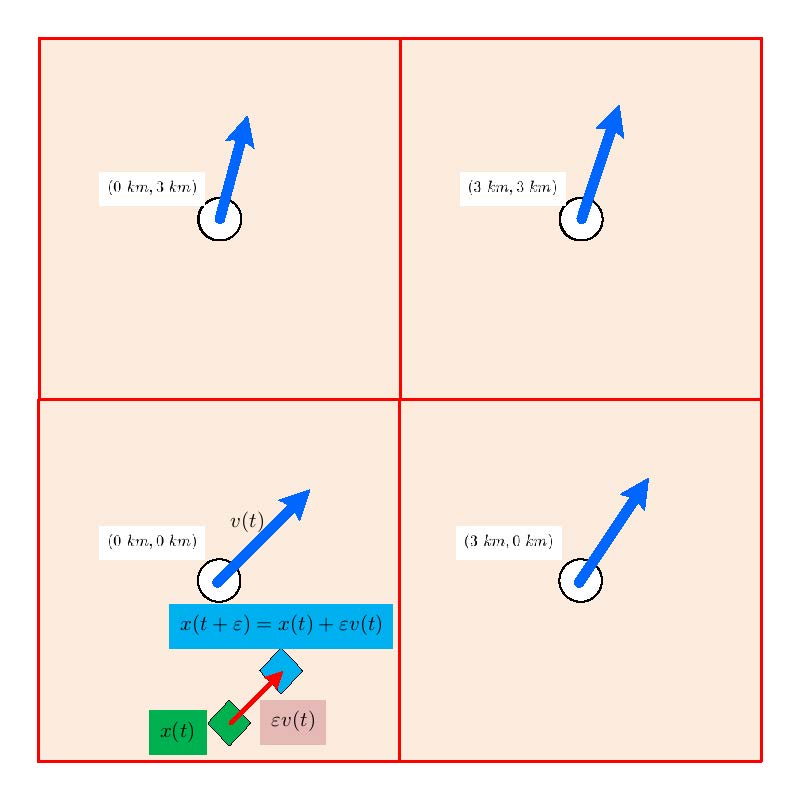

This example shows that at time $t$, a particle is located at a position $x(t)$, shown as a green diamond. After some time $\varepsilon$ has passed, at time $t+\varepsilon$, the particle is at a new location $x(t+\varepsilon)$ shown as a blue diamond. The new location can be computed as the previous location $x(t)$ plus a time displacement computed as the change in time $\varepsilon$ times the velocity at that point $v(t)$.  Note that the velocity is given in distance units per time unit, for example, kilometers per hour. Thus, the location $x(t)$ must be given in the same distance units, e.g., kilometers, and the time displacement $\varepsilon$ should be given in hours.

## The ingredients for simulating a flow:

As noted by the description above, in order to simulate the movement of the particle we need a couple of items:
- A space $\mathcal{X}$ where we want out simulation to be run on. For example for a 2-dimensional space, we can consider a box with unitary lenght, i.e., $\mathcal{X}=[0,1]\times[0,1]$.
- An initial position $x(0)\in\mathcal{X}$. Of course we want our initial position to be inside the space we want to simulate the movement.
- A simulation time $T$. This is the maximum time we would like to run our simulation.
- A time step $T\geq\varepsilon>0$. The unit $\varepsilon$ is going to serve as a discretization of time, and is going to the the smallest unit of time we are going to consider in our simulation. In practice, this means our simulation should output a sequence of positions for times $\{0,\varepsilon,2\varepsilon,3\varepsilon,4\varepsilon,\ldots,T\}$.
- The number $\varepsilon$ also defines the number of iterations we are going to have in our simulation. For example, if $T=10$, and $\varepsilon=2$, then we will run a total of $N=5$ iterations. One can start the oposite direction, by defining the number of iterations first and then compute the corresponding time step. For example, if I want to run $N=300$  iterations, I will have to set \begin{equation} \varepsilon = \frac{T}{N} = \frac{10}{300} \approx 0.033.\end{equation}
- A flow function $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$. This function has two input arguments, namely, a position $x(t)$ and a time $t$, and outputs a vector in $\mathbb{R}^2$ which indicates the velocity that a particle at location $x(t)$ would have in the $x$ and $y$ axis respectively. Note that we have explicitly allowed the flow function to depend on time. That is, flows might change depending not only on the location but of the time index.
- In general, we might not have access to a generic function of the form $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$, specially if our flow comes from data that has been obtained at some particular set of locations. In this case, we might consider a set $\mathcal{G} = \{x_1, x_2, \ldots, x_m\}$ where $x_i\in\mathcal{X}$ for $i\in\{1,2,\ldots,m\}$. These points represents the locations where flow information is available. For simulation purposes in this case, if at some point in time $t \in [0, T]$, the particle is at a location $x(t)$, instead of using the flow $V(x(t),t)$ which might not be available, we will use the surrogate flow $V(x_j,t)$ where $x_j = \mathrm{argmin}_{z\in\mathcal{G}} \;d(z, x(t))$ where $d(\cdot,\cdot)$ is some distance function, for example $d(x,y) = \|x - y\|^2$. This indicates that we will use the flow information at a point $x_j$ in the set of available locations, that is closest to $x(t)$ in some predefined sense.

## The data

The data set may be found in OceanFlow. It consists of the ocean flow vectors for time $T$ from 1 to 100. The flow in the data set is an averaged flow from the surface to either near the bottom or 400m of depth, whichever is shallower. It is thus a 2D vector field. The files contain the horizontal and vertical components of the vectors. The numbers in the file names indicate the time. For instance, files 24u.csv and 24v.csv contain the information of the flow at time index 23 for zero-indexed arrays. The file mask.csv, if needed, contains a 0-1 matrix identifying land and water.

The data were collected in January 2009. Flows are given in kilometers per hour (km/h) units. The time interval between the data snapshots is 3hrs. The first time index (0 for zero-indexed, 1 for one-indexed) will correspond in these problems to the time coordinate of 0 hrs. Thus, for example, 1u-csv gives data at a time coordinate of 0 hours.

The grid spacing used is 3 km. The matrix index (0,0) will correspond in these problems to the coordinate (0km,0km), or the bottom, left of the plot. For simplicity, we will not be using longitudes and latitudes in this problem.

The columns of the -csv files correspond to the horizontal direction (x-axis), the rows of the .csv files correspond to the vertical direction (y-axis).

The data has been provided by the MSEAS research group at MIT (http://mseas.mit.edu/). The flow field is from a data-assimilative multiresolution simulation obtained using their MSEAS primitive-equation ocean modeling system. It simulates tidal flows to larger-scale dynamics in the region, assimilating a varied set of gappy observations.

# Part I - Ocean Flow

<b> The next couple first items are designed to make you comfortable loading, reading, plotting, and computing the data.

First, provide the coordinates (in kilometers) of the point with smallest variation in speed flow (magnitude of the vector). You should first calculate the magnitude for each data point, $\sqrt{u^2+v^2}$, then compute the variance across time.</b>

In [2]:
# Loading data

arys = []
for i in range(1, 101):
    h = pd.read_csv(("OceanFlow/{}u.csv".format(i)), header=None).to_numpy().T # horizontal component vectors
    v = pd.read_csv(("OceanFlow/{}v.csv".format(i)), header=None).to_numpy().T # vertical component vectors
    arys.append(np.transpose(np.array([h, v], dtype=np.float32), [1, 2, 0])) # time, x-coord vector component, y-coord vector component, 
    mask = pd.read_csv(("OceanFlow/mask.csv".format(i)), header=None).to_numpy().T[:,::-1] # in reverse order
data = np.array(arys)

In [3]:
mask.shape # Shows whether the x- and y-coordinates are in land or at sea (i.e. the map)

(555, 504)

In [4]:
data.shape # hours, x-coordinates and y-coordinates in vector components

(100, 555, 504, 2)

In [5]:
# Calculating the magnitude and the variance of the magnitude of each data point

magnitude = np.sqrt(np.square(data).sum(axis=3)) # squaring the sum over the hours, x- and y-coordinates
magnitude_var = magnitude.var(axis=0, ddof=0) # varince over rows
magnitude.shape, magnitude_var.shape

((100, 555, 504), (555, 504))

In [6]:
# Calculating the minimum of the variance of the magnitude and getting location in kilometers

magnitude_var[magnitude_var == 0] = np.inf # changing zeros into positive infinity so that these won't affect calculations
location = np.unravel_index(np.argmin(magnitude_var, axis=None), magnitude_var.shape) # getting index coordinates of min values
print("The location of the minimum variance is {} in x- and y-coordinates (km).".format(np.array(location)*3)) # grid spacing is 3km

The location of the minimum variance is [510 363] in x- and y-coordinates (km).


<b> Provide the coordinates (in Kilometers) and the time stamp (in hours), of the point where the flow has its maximum x-axis velocity (the maximum signed value).</b>

In [7]:
# Calculating the maximum x-axis velocity

max_x_velocity = np.unravel_index(np.argmax(data[:,:,:,0], axis=None), data[:,:,:,0].shape) # index of the max value
print("The time and location of the maximum x-axis velocity is {} in time, x- and y-coordinates (km)".format(np.array(max_x_velocity)*3))

The time and location of the maximum x-axis velocity is [  84 1041  543] in time, x- and y-coordinates (km)


<b> Take the average of the velocity vector over all time and positions, so that you get an overall average velocity for the entire data set. Note you should average over land positions for this problem, do not attempt to remove them from the average.</b>

In [8]:
# Calculating the average velocity over the data set

avg_velocity = data.mean(axis=(0,1,2)) # Average over time, x- and y-coordinates
print("The average of the velocity vector over all time and positions is {} in km/h".format(avg_velocity))

The average of the velocity vector over all time and positions is [-0.09359308 -0.03547521] in km/h


## Long-Range Correlations

<b> In this problem, we will try to identify areas in the Philippine Archipelago with long-range correlations. Your task is to identify two places on the map that are not immediately next to each other but still have some high correlation in their flows. Your response should be the map of the Archipelago with the two areas marked (e.g., circled). You claim that those two areas have correlated flows. Explain how did you found those two areas have correlated flows. </b> 

Below you will find some hints.

A point is a particular location in the provided data set. Moreover, we have 100 measurements (at 100 different times) of the flow speeds in the x-axis and y-axis for each point. To compute the correlation between two points: select two points and compute the correlation coefficient along the x-direction, or the y-direction, or both. That is a correltion between two vectors of dimension 100.

The provided data set is quite large, with a map of 555 x 504 points. Thus, computing the correlation between every possible pair of points might be computationally expensive. You will need to compute (555 * 504)^2 = 78,243,278,400 correlations! That is very large. Instead you can randomly sample pairs of points and compute their correlations.

Since this is a relatively small area, there might be many correlations between the points, so set the threshold to define "high correlations" sufficiently large. If it is too small, you will find that most of the points are correlated. If it is too high, no pairs of points will be correlated.

An area might be a single point correlated with other points. However, maybe there are clusters of points that are correlated with other clusters of points.

Remember that correlation can be positive or negative. You are free to select whether you want to find positively correlated areas or negatively correlated areas.

You are suggested to find a correlation for each direction separately. You are free to select how to combine these two values. Maybe set the correlation between the two points as the maximum directional correlation. Average between the two directional correlations also work. Of course, the minimum as well.

The Pearson correlation between two random variables  $X$ and $Y$, with expected values $\mathbb {E}[X] = \mu _X$ and $\mathbb {E}[Y] = \mu _Y$, and standard deviations $\sigma _X$ and $\sigma _Y$, is defined as
$$\displaystyle  \rho _{XY} = corr(X,Y) = \frac{\textsf{Cov}(X,Y)}{\sigma _ X,\sigma _ Y} = \frac{\mathbb {E}[(X - \mu _ X)(y-\mu _ Y)]}{\sigma _ X \sigma _ Y}.$$

The covariance quantifies the joint variation between two random variables. Formally, the covariance between two real-valued random variables $X$ and $Y$, both with finite second moments, is defined as
$$\displaystyle  \textsf{Cov}(X,Y) = \mathbb {E}[(X - \mu _ X)(y-\mu _ Y)] = \mathbb {E}[XY] - \mathbb {E}[X]\mathbb {E}[Y].$$

In [9]:
# Creating 100000 pairs of locations: 2x2 matrices with random numbers with the shape from x- and y-coordinates

pairs = np.array([np.random.randint(0, data.shape[1], size=[2, 100000]), np.random.randint(0, data.shape[2], size=[2, 100000])]).transpose([2,1,0])
pairs.shape

(100000, 2, 2)

In [10]:
# Calculating distances for pairs

pairs_distance = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(axis=1))
pairs_distance.shape

(100000,)

In [11]:
# Creating threshold for long-distance

pld = pairs[pairs_distance > 350, :, :]
pld.shape

(30302, 2, 2)

In [12]:
# Finding the velocity arrays for each location and taking element-wise product between them with threshold for velocity 

moment = lambda a: np.sqrt(np.square(a).mean(axis=0))
pld = pld[(moment(data[:, pld[:,0,0], pld[:,0,1]]) * moment(data[:, pld[:,1,0], pld[:,1,1]])).min(axis=1) > 0.3]
pld.shape

(396, 2, 2)

In [14]:
# Taking the mean over time to find the second moment of the distribution (i.e. variances)

d_delta = (data - data.mean(axis=0)[None, :, :, :])
div = (moment(d_delta[:, pld[:,0,0], pld[:,0,1]]) * moment(d_delta[:, pld[:,1,0], pld[:,1,1]]))
div.shape

(396, 2)

In [15]:
# Calculating correlation betweeen locations (where the expectation is the average) 

corrs = (d_delta[:, pld[:,0,0], pld[:,0,1]] * d_delta[:, pld[:,1,0], pld[:,1,1]]).mean(axis=0) / div
corrs.shape

(396, 2)

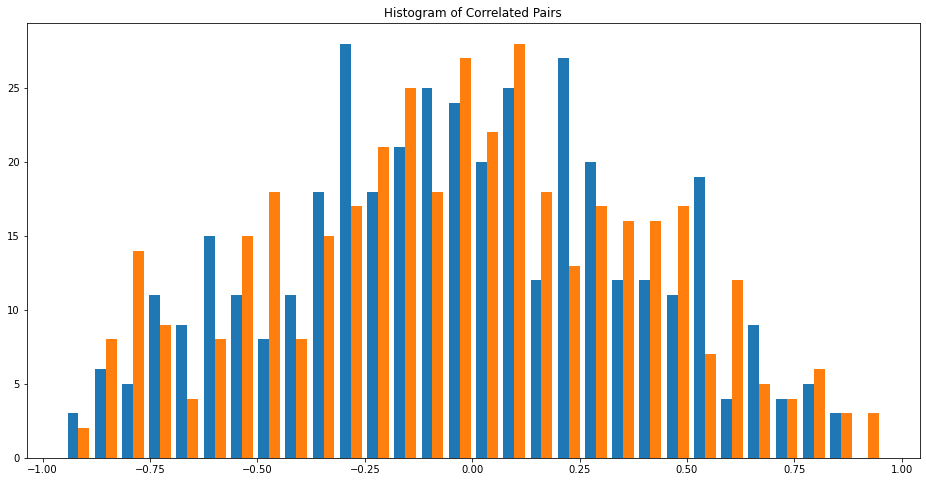

In [16]:
# Plotting histogram of correlated pairs

plt.figure(figsize=(16,8))
plt.title("Histogram of Correlated Pairs")
plt.hist(corrs, bins=30)
plt.show()

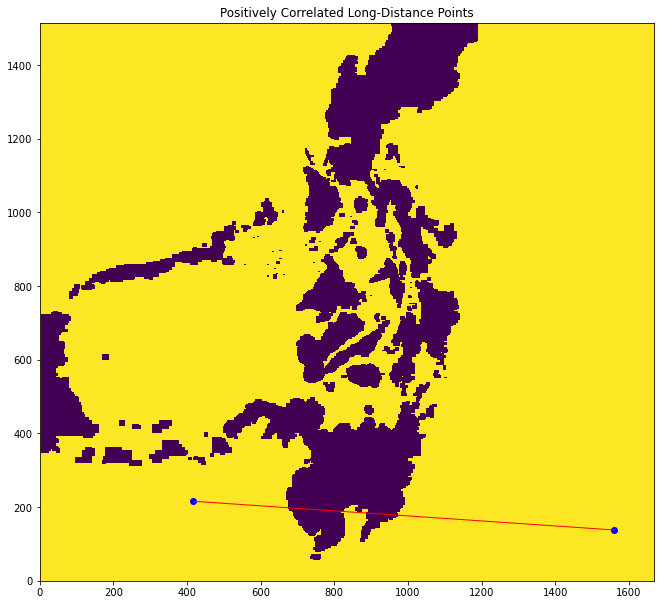

In [27]:
# Plotting positively correlated pair

plt.rcParams["figure.figsize"] = (16,10)
plot_pairs = pld[np.all(corrs >= corrs.min(axis=1).max(axis=0), axis=1)]
x_extent, y_extent = 3*(data.shape[1]+1), 3*(data.shape[2]+1)
plt.matshow(mask.T, origin='lower', extent=[0, x_extent, 0, y_extent])
plt.axis([0, x_extent, 0, y_extent])
plt.title('Positively Correlated Long-Distance Points')
cmap = plt.get_cmap('hsv')
lc = matplotlib.collections.LineCollection(plot_pairs*3, colors=cmap(np.linspace(0, 1, plot_pairs.shape[0]+1))[:-1], linewidths=1)
plt.gca().add_collection(lc)
plt.scatter(*plot_pairs.reshape((-1, 2)).T*3, c='b', marker='o')
plt.gca().xaxis.tick_bottom()
plt.show()

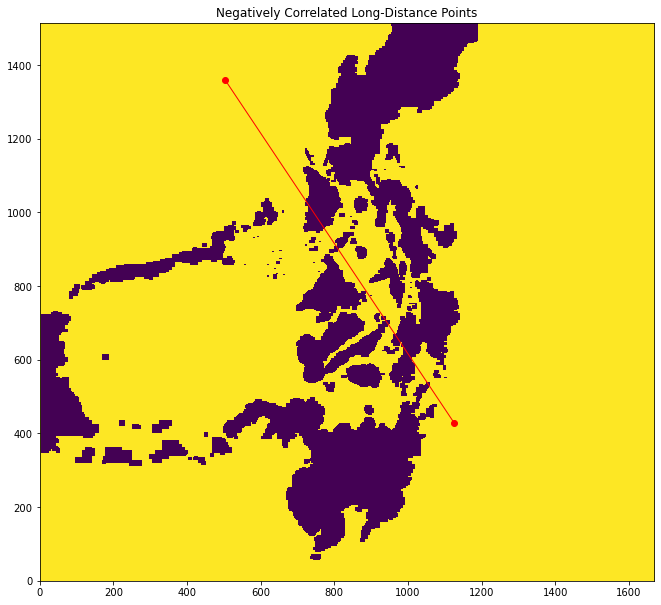

In [28]:
# Plotting negatively correlated pair


plot_pairs = pld[np.all(-corrs >= -corrs.max(axis=1).min(axis=0), axis=1)]
x_extent, y_extent = 3*(data.shape[1]+1), 3*(data.shape[2]+1)
plt.matshow(mask.T, origin='lower', extent=[0, x_extent, 0, y_extent])
plt.axis([0, x_extent, 0, y_extent])
plt.title('Negatively Correlated Long-Distance Points')
cmap = plt.get_cmap('hsv')
lc = matplotlib.collections.LineCollection(plot_pairs*3, colors=cmap(np.linspace(0, 1, plot_pairs.shape[0]+1))[:-1], linewidths=1)
plt.gca().add_collection(lc)
plt.scatter(*plot_pairs.reshape((-1, 2)).T*3, c='r', marker='o')
plt.gca().xaxis.tick_bottom()
plt.show()

The main driving forces of surface ocean currents, according to the U.S. National Oceanic and Athmospheric Administration (NOAA), are caused by wind systems that are fueled by energy of the sun. The patterns of surface currents are determined by wind direction, Coriolis forces from the Earth's rotation, and the position of landforms that interact with the currents. 

Analyzing the plots with this information in mind, we can see from the two maps where the darker space indicates land and yellow the sea, that the highly positively correlated long-distance points (blue points) are on the Southern part of Philippines, the Philippine Sea and Celebes Sea, whereas the highly negatively correlated long-distance points (red points) are located in the opposite directions of North and South. This result shows different weather conditions in the North compared to the South, where the ocean velocity flows are affected differently by the winds blowing at the South China Sea in the north-west, compared to the southern side at the Philippine Sea and the Celebes Sea. From the last map we can also note that the closeness of the land compared to the sea shows that the closeness of to land can also influence the direction and magnitude of the currents compared to the sea.

## Simulating Ocean Flows and Particle Movements

In this problem, you are asked to build a simulator that can track a particle's movement on a time-varying flow.

The data provides a discretization of the ocean flow. The particles will, however, be moving on a continuous surface. For simplicity, let us assume that the surface is the plane $\mathbb {R}^2$. The data can be seen to provide flow information at integer points, namely at $(m,n)$ for $m$ and $n$ integers. Divide the continuous surface into squares in such a way that each square contains a unique data point. One way to achieve this is to assign to every point in the surface the closest data point. For instance, given $x,y) \in \mathbb {R}^2$, this consist of rounding both $x$ and $y$ to the closest integer. You may then suppose that each square has the same flow information as the data point it contains. 

Now take a particle at $(x,y)$ in a particular square. The flow in the square will displace it at the corresponding velocity. Once the particle moves out of this square, it is governed by the flow information of the next square that it enters. 

<b>We assume that the velocity of a particle in the ocean, with certain coordinates, will be determined by the corresponding water flow velocity at those coordinates. Implement a procedure to track the position and movement of multiple particles as caused by the time-varying flow given in the data set. Explain the procedure, and show that it works by providing examples and plots. </b>

<b>Draw particle locations uniformly at random across the entire map, do not worry if some of them are placed on land. Simulate the particle trajectories for 300 hours and provide a plot of the initial state, a plot of the final state, and two plots at intermediate states of the simulation. You may wish to draw colors at random for your particles in order to help distinguish them.</b> 

In [19]:
# Setting up flowplot of vector field, updating and animating plot

# Configuration for simulation
rc('animation', html='jshtml') # JavaScript
plt.rcParams["figure.figsize"] = (12,12) # Size of animation
#matplotlib.rcParams['animation.embed_limit'] = 2**128 # Set larger limit for animation

def flowplot(ax, grid_x, grid_y, title, overlay=None, grid_stride=1, density=False):
  sc_cmap = plt.get_cmap('cool')
  sc = ax.scatter(0, 0, marker='o')
  ax.set_xlabel(r"$x$-axis")
  ax.set_ylabel(r"$y$-axis")
  ax.set_title(title)
  qv = ax.quiver(grid_x[::grid_stride,::grid_stride], grid_y[::grid_stride,::grid_stride], 
                 np.ones_like(grid_x[::grid_stride,::grid_stride]), np.ones_like(grid_y[::grid_stride,::grid_stride]))
  if overlay:
    overlay(ax)
  def update(new_loc, new_fl = None, new_title=None):
    sc.set_offsets(new_loc)
    if density:
      from scipy.stats import gaussian_kde
      estimate_points = new_loc[np.all([new_loc[:,0]>grid_x[3,0], 
                                        new_loc[:,0]<grid_x[-3,0],
                                        new_loc[:,1]>grid_y[0,3], 
                                        new_loc[:,1]<grid_y[0,-3]], axis=0) ]
      cs = gaussian_kde(estimate_points.T)(new_loc.T)
      sc.set_facecolors(sc_cmap((cs-cs.min())/cs.max()))
    if new_title:
      ax.set_title(new_title)
    if new_fl:
      qv.set_UVC(new_fl[0][::grid_stride,::grid_stride], new_fl[1][::grid_stride,::grid_stride])
      return sc, qv
    else:
      return sc,
  return update

def animate(state, g_x, g_y, title, overlay=None, grid_stride=1, density=False):
  fig, ax = plt.subplots()
  update_plot = flowplot(ax, 
                         g_x, g_y, 
                         title.format(0),
                         overlay,
                         grid_stride,
                         density)

  def frame(s):
    x, t, v, fl_x, fl_y = s
    return update_plot(x,
                      new_fl = (fl_x, fl_y), 
                      new_title=title.format(t))

  animation = anim.FuncAnimation(fig, frame, frames=state, blit=True)
  plt.close()
  return animation

In [ ]:
# Simulating flowplot for 300 hours and with 30 particles

T = 300.0 # Simulation time
N = 200 # Number of iterations
num = 30 # Number of particles
epsilon = T/N # Time steps


t = np.arange(0, T, epsilon) # Vector of times

# Creating the vector field with the edges and the midpoint
midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_t_edges = np.arange(0, data.shape[0]+1)*3 # 3 hrs per point

g_x_edges = np.arange(0, data.shape[1]+1)*3 # 3 km per point
g_y_edges = np.arange(0, data.shape[2]+1)*3 # 3 km per point
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges)) # Coordinate matrice 


# Initializiation of particles randomly around the map
x_0 = np.array([ np.random.rand(num)*g_x_edges.max(), np.random.rand(num)*g_y_edges.max() ]).T

# To extend the vector field outside of the [0,1] range
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

def get_grid(t):
    '''Finds the time indices vt where elements should be inserted to maintain order.
    '''
    vt = clamp(np.searchsorted(g_t_edges, t), 1, g_t_edges.shape[0]-1)
    return data[vt-1]

def get_v(grid, x):
    '''Finds the velocity indices vi and vj where elements should be inserted to maintain order.
    '''
    vi = clamp(np.searchsorted(g_x_edges, x[:,0]), 1, g_x_edges.shape[0]-1)
    vj = clamp(np.searchsorted(g_y_edges, x[:,1]), 1, g_y_edges.shape[0]-1)
    return grid[vi-1,vj-1,:]

def plot_overlay(ax):
    '''Plots the 2D mask matrix as color-coded image by the grid edges. 
    '''
    ax.matshow(mask.T, origin='lower', extent=[0, g_x_edges.max(), 0, g_y_edges.max()])
    ax.axis([0, g_x_edges.max(), 0, g_y_edges.max()])

# For loop that keeps track of the changes in the state
state = [(x_0, 0.0, get_v(get_grid(0.0),x_0),*get_grid(0.0).transpose([2,0,1]))]
for i in range(N):
  x, t, v, _, _ = state[-1]
  
  v_t_grid = get_grid(t) # Adjusting indices with the right time
   
  v = get_v(v_t_grid, x) # Adjusting velocity indices
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time
  
  state.append(
      (x, t, v, v_t_grid[:,:,0], v_t_grid[:,:,1])
      )
    
animate(state, g_x, g_y,"{}",overlay=plot_overlay, grid_stride=20)

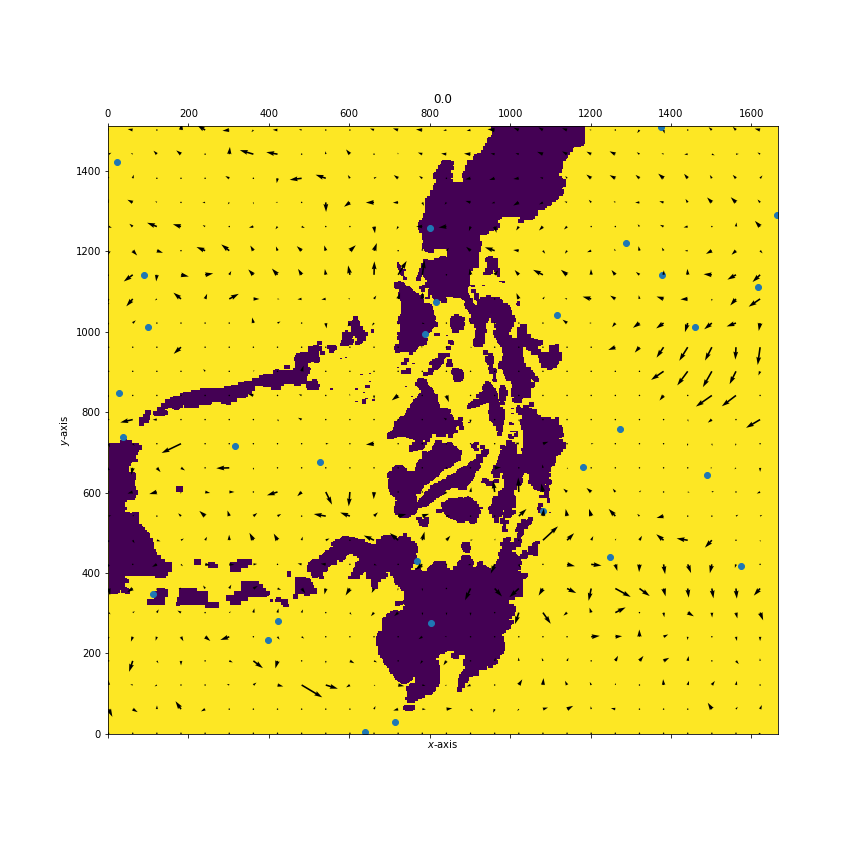

The simulation algorithm is first initialized in the state $s_0$, which contains the initial position of each particle to be simulated, and the current time step of the simulation:
\begin{equation}
  s_0 = (x_0, t_0).
\end{equation}
For each step of the simulation, the flow velocity is found by first digitizing the current time step, $t_i$, of the simulation into an index for the data array of velocities. This digitization is performed through a binary search into an array of time stamps that mark the boundaries between data points in the data array. 

The particle locations, $x_i$, are then digitized in the same way, using arrays of locations that mark the boundaries between data points. With these three indicies, the appropriate velocity vector is retreived from the data array.

The current location of each particle is then advanced by one time step:
\begin{equation}
  x_{i+1} \leftarrow x_i + \epsilon v_{i+1},
\end{equation}
where $v_i$ is the velocity at step $i$ as detailed above, $x_{i+1}$ and $x_i$ are the next and current locations of the particles, and $\epsilon$ is the time delta between simulation steps.

The current time step of the simulation is also advanced by $\epsilon$:
\begin{equation}
  t_{i+1} \leftarrow t_i + \epsilon.
\end{equation}

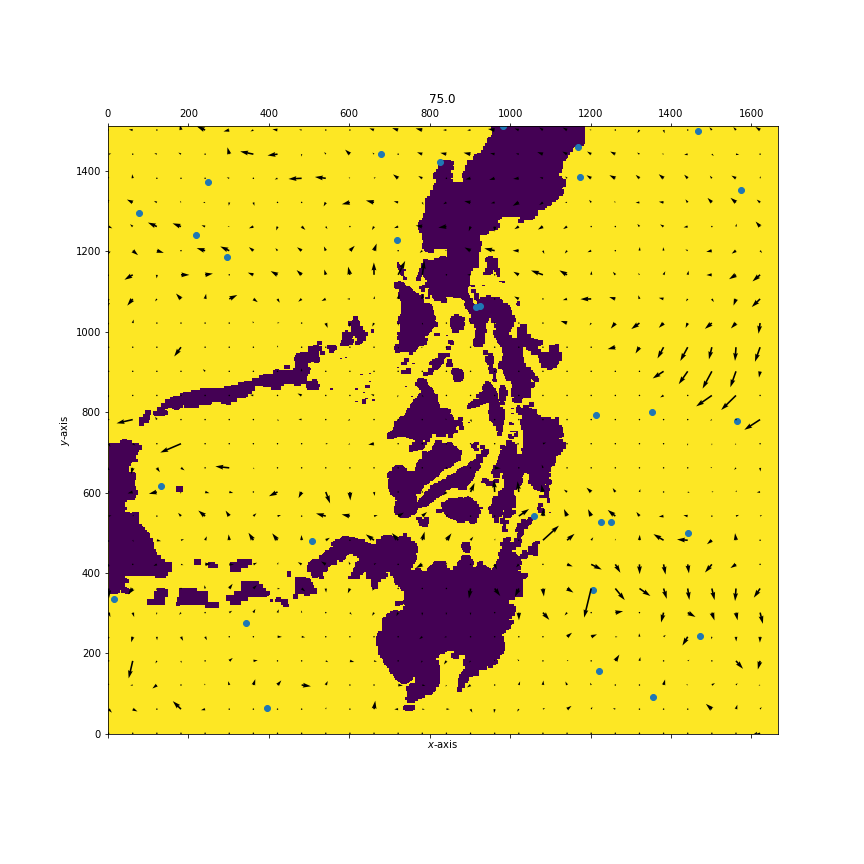

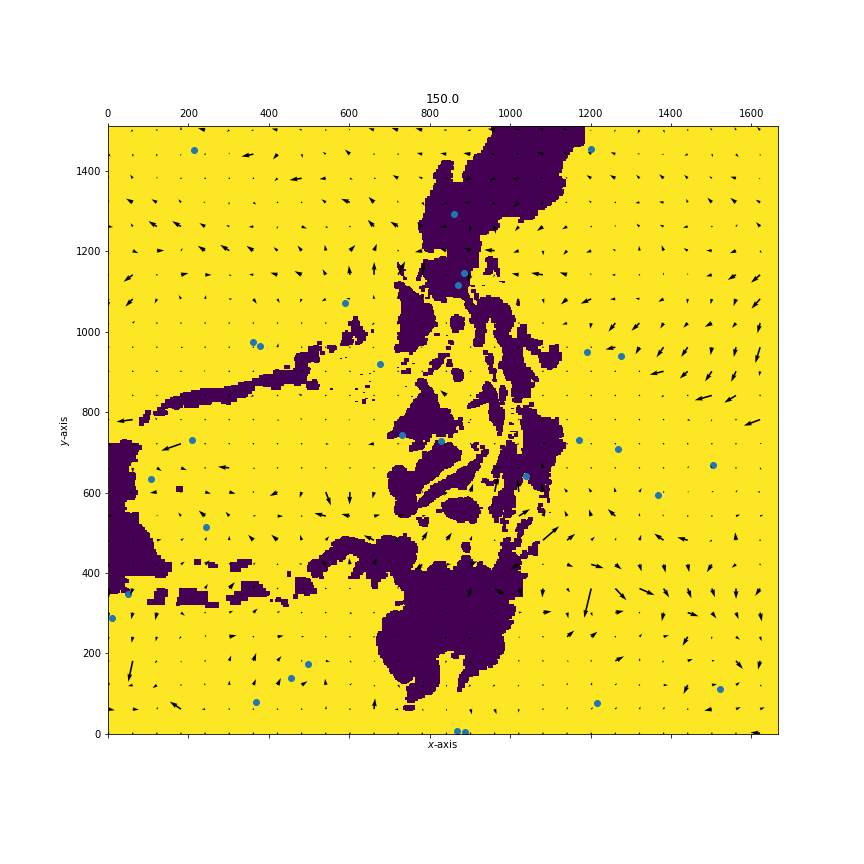

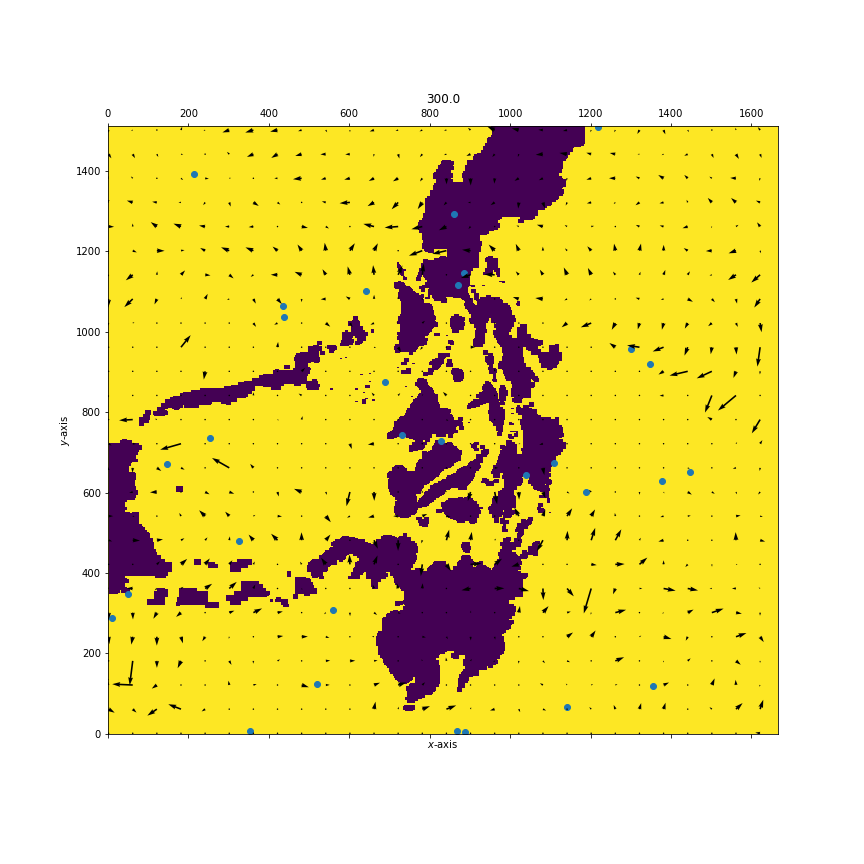

The four pictures show the progress of the animation starting from 0 hours and moving towards 75 and 150 hours, before finishing of the simulation at 300 hours. As we can see from the pictures, some of the particles did start from land but didn't move at all, but the ones that did start at the sea, moved around until they found land or the end of the map. 

<b> A (toy) plane has crashed north of Palawan at $T=0$. The exact location is unknown, but data suggests that the location of the crash follows a Gaussian distribution with mean $(100,350)$ (namely $(300km,1050km)$) with variance $\sigma^2$. The debris from the plane has been carried away by the ocean flow. You are about to lead a search expedition for the debris. Where would you expect the parts to be at 48hrs, 72hrs, 120hrs? Study the problem by varying the variance of the Gaussian distribution. Either pick a few variance samples or sweep through the variances if desired.</b>

In [ ]:
# Simulating flowplot where particles start at (300km, 1050km) with varying variance

T = 300.0 # Simulation time in hours
N = 200 # Number of iterations
num = 30 # Number of particles
epsilon = T/N # Time steps


t = np.arange(0, T, epsilon) 

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_t_edges = np.arange(0, data.shape[0]+1)*3 
g_x_edges = np.arange(0, data.shape[1]+1)*3 
g_y_edges = np.arange(0, data.shape[2]+1)*3 
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))

# For loop to start particles at (300km, 1050km) with 3 different variances
for x_0_variance in [10**2, 30**2, 50**2]:
  x_0 = np.random.multivariate_normal(mean=[300, 1050], cov=[[x_0_variance, 0], [0, x_0_variance]], size=num)

  state = [(x_0, 0, get_v(get_grid(0.0), x_0), *get_grid(0.0).transpose([2,0,1]))]
  for i in range(N):
    x, t, v, _, _ = state[-1]
  
    v_t_grid = get_grid(t)
   
    v = get_v(v_t_grid, x)
  
    x = x + epsilon*v 
    t = t + epsilon 
  
    state.append(
      (x, t, v, v_t_grid[:,:,0], v_t_grid[:,:,1])
      )
    
animate(state, g_x, g_y,"{}",overlay=plot_overlay, grid_stride=20)

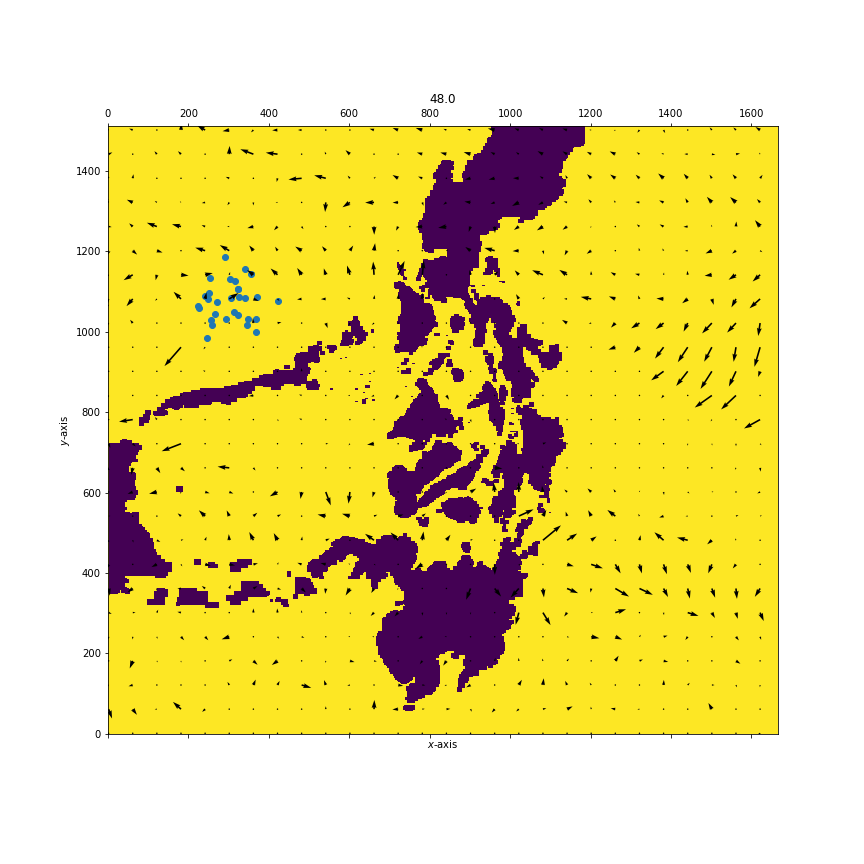

From the first picture of the animation at 48h, with $\sigma^2=10^2$, we see that the bulk of the particles do not move very far. Thus  we should not look much further afield than the supposed crash location.

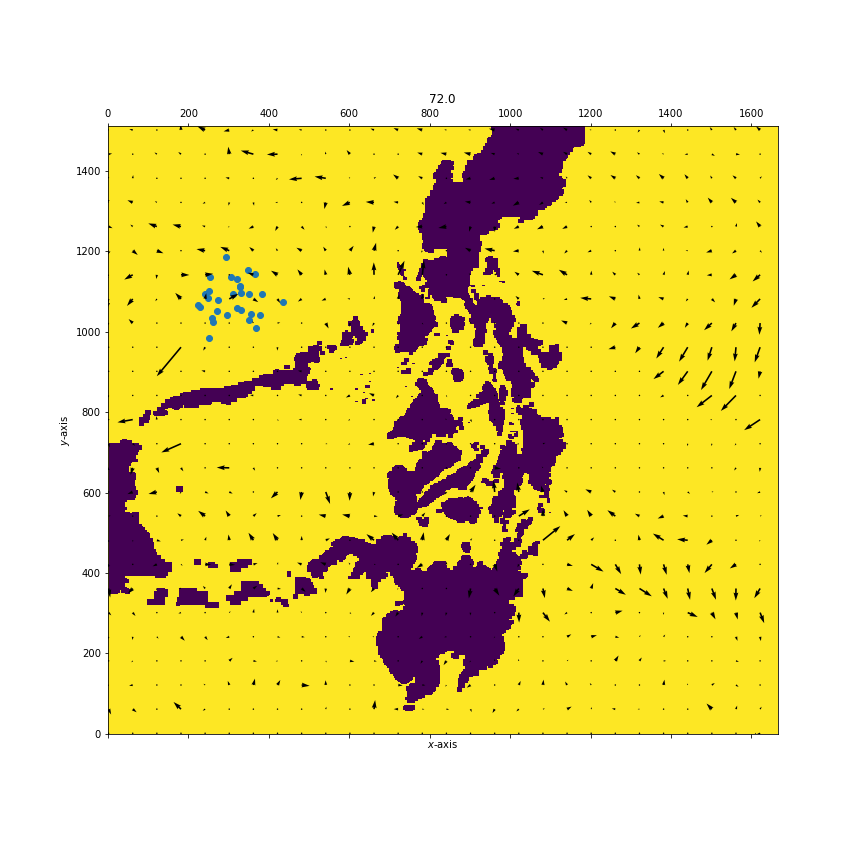

After 72 hours, the particles are located pretty much at the same place still as the crash site as they are after 120 hours.

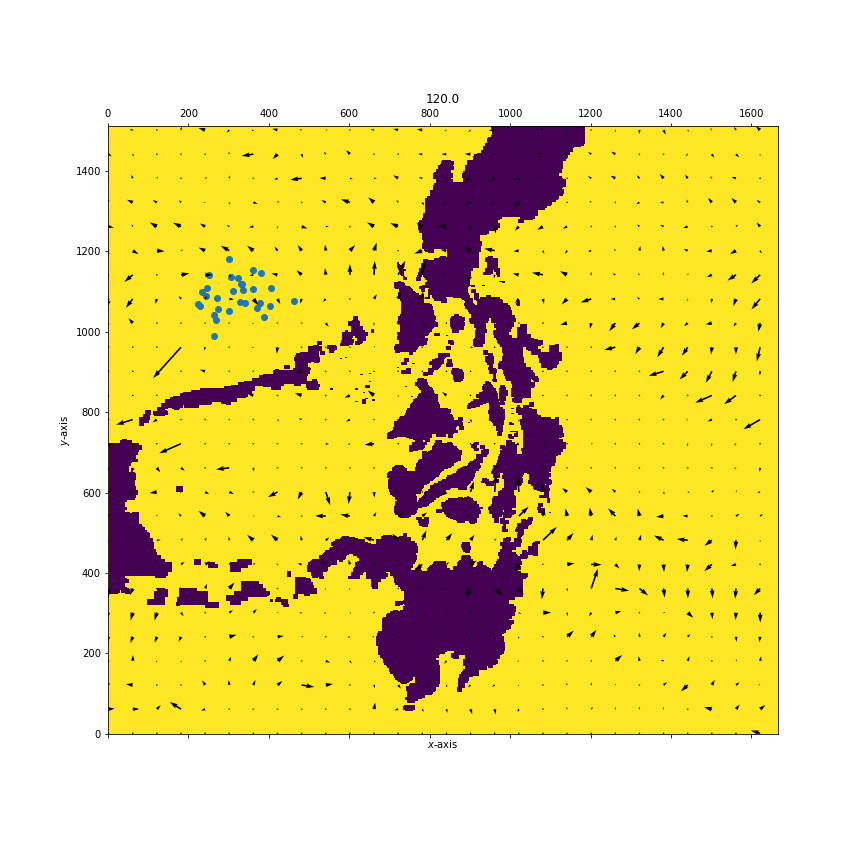

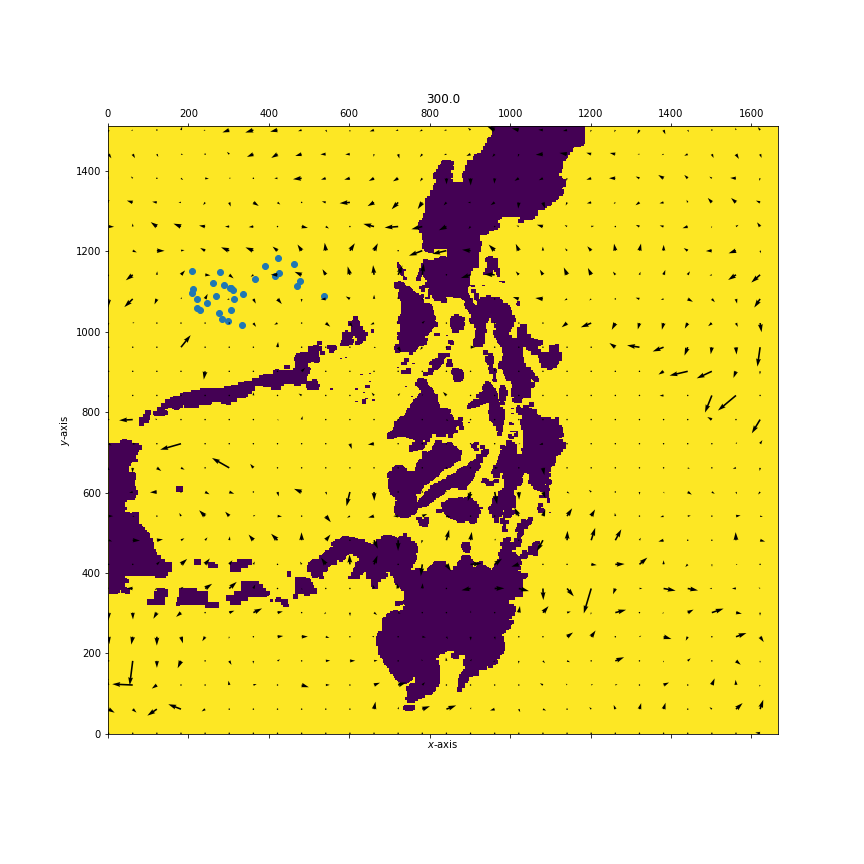

Once we increase the variance, especially towards the last animation, with $\sigma^2=50^2$, we see that the tails of the uncertainty distribution are squashed into somewhat of a line, creating an asymmetric shape where some of the particles drift towards the center of the island of Palawan and some towards the capital Manila. We should use this as a plan of a search by plane, where the plane could fly from the center of Palawan towards the crash site and from there take a turn towards Manila or vice versa.

# Part II - Estimating Flows with Gaussian Processes


In the previous exercises, we studied flow data. The data we used were given for a set of physical locations, and for each location, over 100-time instances each separated by 3 hours.  In the previous exercise, we simulated the debris's possible locations after a specific time, given some estimated location of a (toy) plane crash. However, because we only have data for 100-time instances, separated 3 hours each, technically, we can only run such simulation for a total of 300 hours. We can see from the previous exercise that in the debris simulation based on this time scale, the points did not move too much or too far. 

In this problem, we will perform a toy experiment where we can simulate larger time scales. Furthermore, we are going to model flows as a Gaussian process to estimate some unobserved variables.

Here onward, we are going to assume that the flow data available, instead of being given measurements every 3 hours, is given for measurements every three days! This implies that we can potentially simulate the movement of debris for almost one year.

However, to achieve a sufficiently smooth simulation, having flow data every three days seems quite a stretch. Whereas in the previous problems we assumed that the flow in the ocean remains approximately the same on a period of 3 hours, to assume that this is also the case for three days does not seem correct. For example, we would like to have time steps of 24 hours, 12 hours or possibly even smaller. 


## Gaussian Process Model

<b> In this problem, we will create a Gaussian process model for the flow given the information we have.</b> 

<b>Pick a location of your liking from the map for which you are given flow data (ideally from a location on the ocean not in the land). Moreover, consider the two vectors containing the flow speed for each direction: you will end up with two vectors of dimension 100.</b>

<b>You are asked to find the parameters of the kernel function that best describes the data independently for each direction. That means you will do the following for each direction, and you will obtain a model for each direction at that particular location. Find the instructions below. For each step, please clearly state your selections, your thought process, and design choices.</b>

<b>Recall the steps to estimate the parameters of the kernel function.</b>

- <b>Pick a kernel function.</b> Here you are free to chose the kernel function you find adequate. Please clearly explain your selection.

- <b>Identify the parameters of the kernel function.</b> E.g. the squared exponential kernel function:

$$\displaystyle  K(z_ i,z_ j) = \sigma ^2\exp \left(-\frac{\| z_ i-z_ j\| ^2}{\ell ^2}\right).$$

where the parameters will be $\theta = \{ \sigma ,\ell \}$

- <b>Find a suitable search space for each of the parameters. </b> For $\ell$ you may wish to consider a range such as 7.2 hours to 360 hours (0.1 to 5 time indices).

You will find a good set of parameters via cross-validation. Pick a number $k$ and split the data $k$-wise defining some training and some testing points. Each vector is of dimension 100, so let us say you picked $k=10$. So you will have ten different partitions, where there are 90 points for training and 10 points for testing.

For each possible set of parameters and each data partition. 

- Build an estimate for the mean at each possible time instance. For example, you can estimate the mean as all zeros, or take averages – moving or otherwise – over your training data. 

- Construct the covariance matrix for the selected kernel functions and the selected set of parameters. 

- Compute the conditional mean and variance of the testing data points, given the mean and variance of the training data points and the data itself. Recall that: 

$$\displaystyle  \mu_{\mathbf{X}_1|\mathbf{X}_2}\displaystyle  = \mu _1 + \Sigma _{12}(\Sigma _{22}+\tau I)^{-1}(\mathbf{x}_2-\mu_2).$$
$$\displaystyle \Sigma_{\mathbf{X}_1|\mathbf{X}_2}\displaystyle  = \Sigma_{11} - \Sigma_{12}(\Sigma_{22}+\tau I)^{-1}\Sigma_{21}.$$

In this case, $X_1$ are the velocities for the testing data-points, $X_2$ are the velocities for the training data-points. $\mu_1$ are the mean velocities for the testing data-points. $\mu_2$ are the mean velocities for the training data-points. $\Sigma_{22}$  is the covariance of the training data-points. $\Sigma _{11}$ is the covariance of the testing data-points. $\Sigma _{12}$ is the cross-covariance. $\mathbf{x}_2$ are the observed velocities for the training data-points. Finally, $\tau$ is the parameter indicating the variance of the noise in the observations. You can pick $\tau = 0.001$

- Compute the log-likelihood performance for the selected parameters. You are free to select to compute it only on the testing data, or on the complete vector. 

<b>For each possible set of parameters, you will then have the performance for each of the $k$ partitions of your data. Find the parameters that maximize performance. Save the computed cost/performance metric for each choice of parameters, then create a plot over your search space that shows this metric.</b> 

Note that you may run into numerical issues during this step. If you do, consider some of the following:

- Ensure you are working with 64-bit (double precision) floating point representations. Some linear algebra libraries default, or even silently enforce (such as JAX) 32-bit representations.

- Use routines for the solution for linear systems of equations to invert your matrices, avoid computing inverses directly (numpy.linalg.solve routine can take two matrices as arguments).

- Large length-scales can cause your covariance matrix to be near-singular. This is caused by tight correlations between neighboring predictions. If you run into this issue you may wish to try: sparsifying your predictions by skipping every second element, or increasing the number of folds in your cross-validation; whitening your data; choosing a different kernel. 

As was already proposed as an example in the problem description, the squared exponential kernel function (i.e. the Radial Basis Function (RBF) or Gaussian Kernel) is a good choice to try to find the probability distribution of the data, as it provides some good properties of being universal and being able to find similarity in infinite dimensions. It has also only two parameters: $\theta = \{ \sigma ,\ell \}$; where $\sigma$ determines the average distance of the random variable away from its mean or the height of the random variable, and $\ell$ that determines the length or the flatness of the random variable.

The Gaussian Kernel specifies the degree of similarity between the random variables given their relative positions in parameter space. If two known training data-points $X_{21}$ and $X_{22}$ are close together then the observed test data-points $X_{11}$ and $X_{12}$ may also be similar, depending on the kernel function and its parameters.

In [20]:
# Creating a Gaussian Process to compute the conditional probabilities

def gaussian_process(x1_mean, x2_mean, x2, covs, tau):
    '''Computes the conditional mean and variance of datapoints with linalg.solve
    that solves a linear matrix equation without having to solve its inverses.
    '''
    cov_noise = covs[1][1] + tau * np.eye(x2_mean.shape[0])
    x1_mean_cond_x2 = x1_mean + covs[0][1]@(np.linalg.solve(cov_noise, x2 - x2_mean))
    x1_cov_cond_x2 = covs[0][0] - covs[0][1]@(np.linalg.solve(cov_noise, covs[0][1].T))
    return x1_mean_cond_x2, x1_cov_cond_x2

In [21]:
# Creating a Gaussian Kernel to compute covariances

def gaussian_kernel(zi, zj, sigma, ell):
    '''Computes the covariances with the squared exponential kernel function.
    '''
    covs = (sigma**2) * np.exp(- (zi[:, None]-zj[None, :])**2 / ell**2 )
    return covs

For validating the generalization of the model when applied to independent data we use the statistical technique of cross-validation where we first split the whole dataset into various disjoint train and test subsets, and then use the Gaussian Process model to form a prediction of the test data using the train data. We then use the results of the performance to validate the model's ability to predict new data that was not part of the training set and to see whether the model produces good results or not.

In the $K$-fold Cross-validation we partition the data set into $K$ disjoint subsets. Then, we train $K$ models, each one with one of the partitions selected as the test set and the remaining subsets are used to form the training set. 

In [22]:
# Creating a function for K-fold Cross-Validation

def kfold_cross_validate(K, values, means, cov, tau):
    '''Cross-validating the data by modeling with the Gaussian Process and creating
    Gaussian random variables with the conditional probabilities. Returns the average
    of the validations as a list.
    '''
    permutate = np.random.permutation(values.shape[0])
    folds = list(map(np.sort, np.array_split(permutate, K)))
    
    def validate(i):
        test = folds[i]
        train = np.array(sorted(list(set(permutate) - set(test))))
        
        covs = [
            [ cov[test[:, None], test], cov[test[:, None], train] ],
            [ cov[train[:, None], test], cov[train[:, None], train] ]
        ]
        
        x1_mean_cond_x2, x1_cov_cond_x2 = gaussian_process(means[test], means[train], values[train], covs, tau)
        x1_cov_cond_x2 = x1_cov_cond_x2 + 1E-10 # For numerical stability in calculations
        I = np.eye(x1_cov_cond_x2.shape[0])
        gaussian_rv = multivariate_normal.logpdf(values[test], mean=x1_mean_cond_x2, cov=x1_cov_cond_x2 * I)
        return gaussian_rv
    
    return np.mean(list(map(validate, range(K))))

After creating functions to calculate the conditional probabilities of the means and covariances we start calibrating and searching for $\theta = \{ \sigma ,\ell \}$ with a $k=10$ folds for the cross-validation.

For $\ell$, it was suggested to consider a range as 7.2 hours to 360 hours (0.1 to 5 time indices). We will thus scan over the range of $7.5$ hours to $375$ hours with $100$ linearly spaced points where each points is separated by $72$ hours or $3$ days. 

For $\sigma$, we will compute the second moment of the velocity data, and use that as a baseline for the scan. We will then scan in range of $0.1$ times this moment, to $10$ times this moment, with $100$ points linearly spaced. This way, we tend to keep the amount of correlation on the same scale as the absolute magnitude of the data.

Finally, for $\tau$ which is the parameter indicating the variance of the noise in the observations we choose $\tau = 0.001$ which was proposed in the briefings.

In [23]:
# Creating a function to run the cross-valiation over data while saving the best results

def scan(K, values, means, tau, covs):
  best = -np.inf
  best_coords = None
  grid = []
  for coords, cov in covs:
    metric = kfold_cross_validate(K, values, means, cov, tau)
    if metric > best:
      best = metric
      best_coords = coords
    grid.append(list(coords) + [metric])
  grids = np.array(grid).T
  return best_coords, grids

In [24]:
# Creating a functon to run the Gaussian Kernel over data

def scan_seq(zs, sigma_scan, ell_scan):
  for sigma in sigma_scan:
    for ell in ell_scan:
      yield (sigma, ell), gaussian_kernel(zs, zs, sigma, ell)

In [25]:
# Creating a function to run both scans over the parameters search range

def scan_position(loc, tau):
  sigma_scan = np.linspace(0.1, 10.0, 100) # [0.1 to 10] with 100 data point spacing
  ell_scan = 75*np.linspace(0.1, 5.0, 100) # [7.5 hrs to 375 hrs] with 100 data point spacing
  for values in [ data[:, loc[0], loc[1], 0], data[:, loc[0], loc[1], 1] ]:
    values = values[::1] # start, stop, stride
    grid_longT_edges = np.arange(0, data.shape[0]+1)*(3*24) # 3 days per data point
    z_locations = grid_longT_edges[:-1:1]
    val_std = np.sqrt(np.square(values).mean())
    result, result_grids = scan(10, values, np.zeros_like(values), tau, scan_seq(z_locations, val_std*sigma_scan, ell_scan))
    yield result, result_grids

In [26]:
# Scanning a location (1400 km, 400 km) in the Eastern part of Philippines, South China Sea

scanned_location = list(map(lambda p: list(scan_position(p, 0.001)), [[1400//3, 400//3]]))

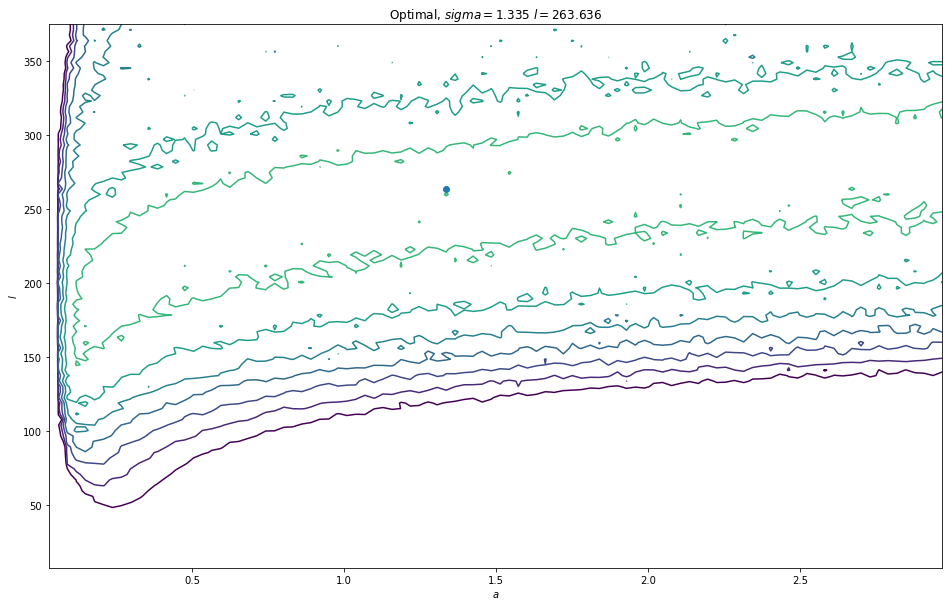

In [29]:
# Plotting the results of the scan with Contour plots

def plot_scan_results(locations, level_range=(0, 30)):
  best, grids = locations
  x_grid, y_grid, z_grid = map(lambda a: a.reshape((100, 100)), grids)

  plt.contour(x_grid, y_grid, z_grid, levels=np.linspace(level_range[0], level_range[1], 10))
  plt.scatter(*best, marker='o')
  plt.title(r"Optimal, $sigma={:.3f}$ $l={:.3f}$".format(*best))
  plt.xlabel(r"$a$")
  plt.ylabel(r"$l$")

plot_scan_results(scanned_location[0][0])

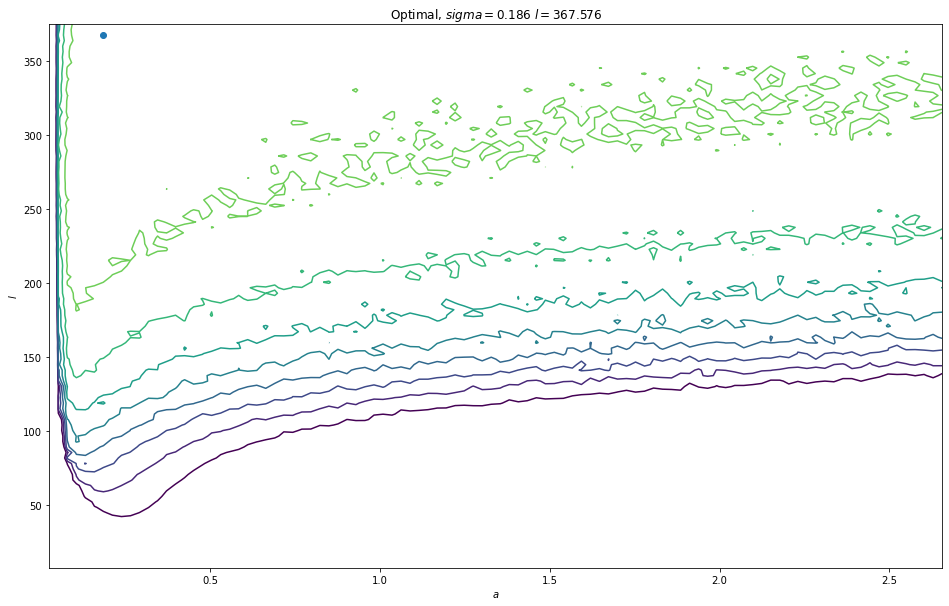

In [30]:
plot_scan_results(scanned_location[0][1])

The Contour plots show the peak point of the density function from where we should select the parameter values. For the first vector component we find $\sigma$ = 1.335 and $\ell$ = 263.636 and for the second $\sigma$ = 0.186 and $\ell$ = 367.576. $\ell$ which describes how quickly the correlation between two points drops as the distance between them increases gives a simpler and smoother function with higher values such as we have now. $\sigma$ which describes how much span the function has vertically has some shakyness of uncertainty on the lines especially at the inner circles of the contour lines.

<b> Run the process described in the point (a) for at least three more points in the map, you free to choose more if you wish. What do you observe? Which of your kernel parameters show patterns? Which do not?</b>

In [31]:
# Scanning East, West, North-West and North-East parts in the oceans of Philippines

scanned_locations = list(map(lambda p: list(scan_position(p, 0.001)), [
            [1400//3, 400//3],
            [400//3, 600//3],
            [500//3, 1400//3],
            [1200//3, 1200//3]
]))

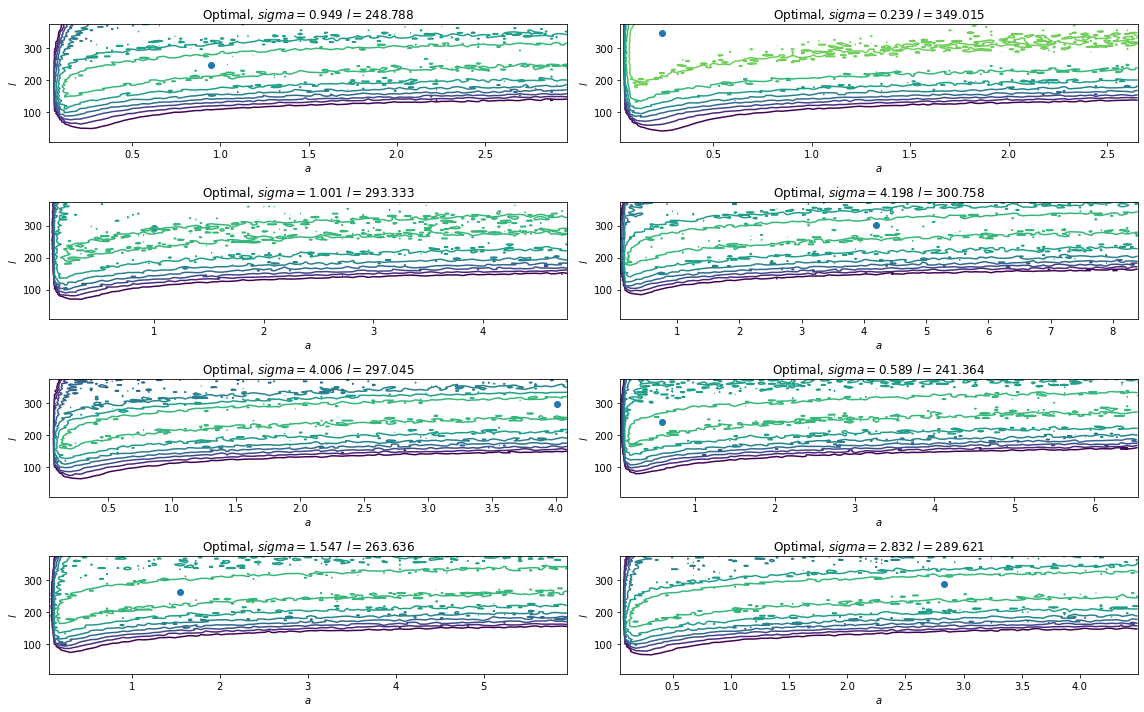

In [32]:
# Plotting the results of the scan with Contour plots

for i, pos_results in enumerate(scanned_locations):
  for j, comp_results in enumerate(pos_results):
    plt.subplot(len(scanned_locations), 2, 1 + 2*i + j)
    plot_scan_results(comp_results)
    
plt.tight_layout()

We can see that $\sigma$ ranges from $0.239$ to $4.198$ with an average around $1.92$ and for $\ell$, by taking the average from a range of values from a mimum of 241.364 to 349.015 we get around $285$.

When comparing the results to the previous, one location search, we get a bit more of fluctuation and uncertainty on the parameters of $\theta$ and $\ell$. From the updated results we could choose $\sigma$ to be $2$ and $\ell$ $285$.

<b> We have suggested one particular value for $\tau$. Consider other possible values and comment on the effects such parameter has on the estimated parameters and the estimation process's performance. Try at least two values different from that used previously.</b>

In [33]:
# Scanning the first location (1400 km, 400 km) with some uncertainty 

scanned_location_with_noise = list(map(lambda tau: list(scan_position([1400//3, 400//3], tau)), [
            0.001, 0.01, 0.1
]))

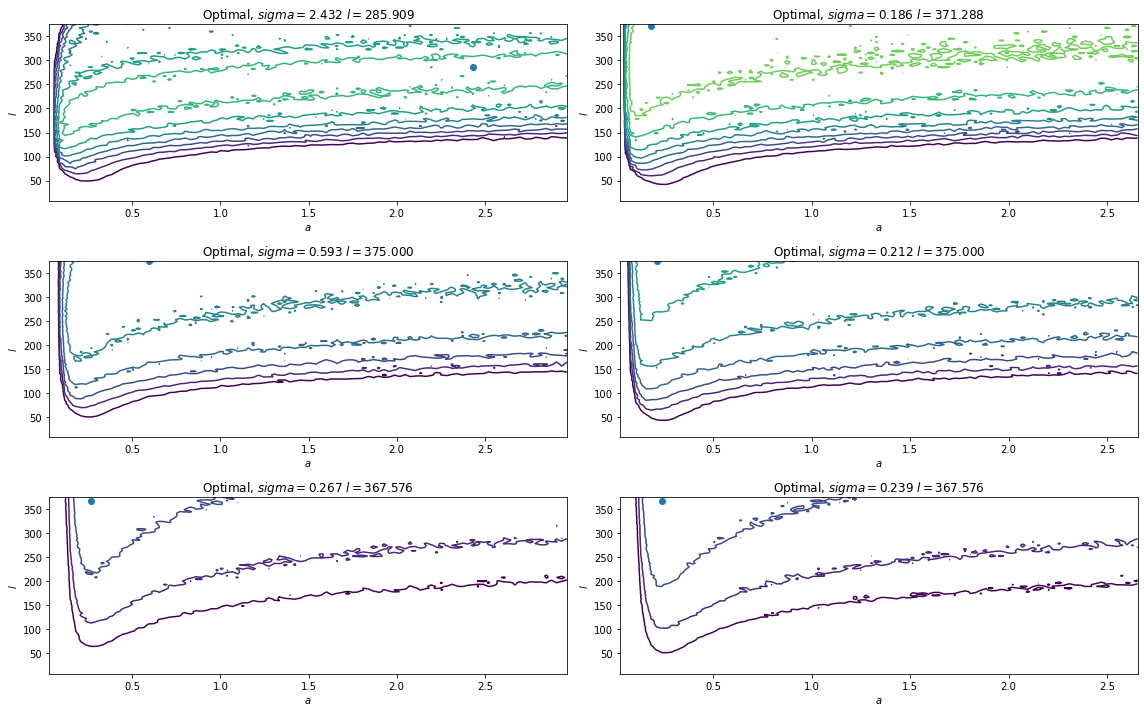

In [34]:
# Plotting the results of the scan with Contour plots

for i, pos_results in enumerate(scanned_location_with_noise):
  for j, comp_results in enumerate(pos_results):
    plt.subplot(len(scanned_location_with_noise), 2, 1 + 2*i + j)
    plot_scan_results(comp_results)
    
plt.tight_layout()

The top row plots show when the calibration is done with low uncertainty $\tau=0.001$. After we increase the uncertainty in $\tau$ this causes the correlation time-scale, $\ell$, to increase until it reaches the edge space, while the original choice of $\tau$ is still located within the search space. Both of the new choices, $\tau=0.01,0.1$, are similarly located close the edges of the search space which indicate adding only a very low amount of uncertainty achieves the best results.

<b>Currently, most of the commonly used languages like Python, R, Matlab, etc., have pre-installed libraries for Gaussian processes. Use one library of your choice, maybe the language or environment you like the most, and compare the obtained results. Did you get the same parameters as previously? If not, why are they different? Elaborate on your answer.</b>

The Gaussian Process algorithm in the `scikit-learn` Python library has an API that takes a kernel that is built using kernel objects also defined by the API. The values specified for the parameters of this kernel are the starting locations for the search that the algorithm will perform.

The `ConstantKernel` provides the value of $\sigma$, while the `RBF` is an exponential of the squared distance between the points. The algorithm has a value `alpha` similar to simulate the measurement error which can act as the $\tau$ parameter.

In the `fit` method, the algorithm performs a search in the parameter space for the best kernel parameters, which we can then access through the `.kernel_` field. We scan over the values of the logarithms of $\sigma$ and $\ell$ and call the `log_marginal_likelihood` to get the optimization target. 

In [35]:
# Gaussian Process Regressor with ConstantKernel and RBF Kernel on Scikit-learn

def scikit_scan_position(loc, tau):
  sigma_scan = np.linspace(0.1, 10.0, 100) # same parameter space
  ell_scan = 75*np.linspace(0.1, 5.0, 100) # same parameter space
  for values in [ data[:, loc[0], loc[1], 0], data[:, loc[0], loc[1], 1] ]:
    values = values[::1]
    grid_longT_edges = np.arange(0, data.shape[0]+1)*(3*24) # 3 days per data point
    z_locations = grid_longT_edges[:-1:1]
    val_std = np.sqrt(np.square(values).mean())

    GPR = GaussianProcessRegressor(
        kernel = ConstantKernel(constant_value=val_std, constant_value_bounds=(val_std*0.1, val_std*10.0)) * RBF(length_scale=100.0, length_scale_bounds=(7.5, 375)), 
        alpha = tau 
        ).fit(z_locations.reshape(-1, 1), values)

    result = np.exp(GPR.kernel_.theta) # transforming log-results

    grid = []
    for sigma in sigma_scan:
      for ell in ell_scan:
        grid.append([sigma, ell, GPR.log_marginal_likelihood(np.log([sigma, ell]))]) # taking logs
    result_grids = np.array(grid).T
   
    yield result, result_grids

In [36]:
# Scanning the same 4 locations with Scikit-learn model

scikit_scanned_locations = list(map(lambda p: list(scikit_scan_position(p, 0.001)), [
            [1400//3, 400//3],
            [400//3, 600//3],
            [500//3, 1400//3],
            [1200//3, 1200//3]
]))

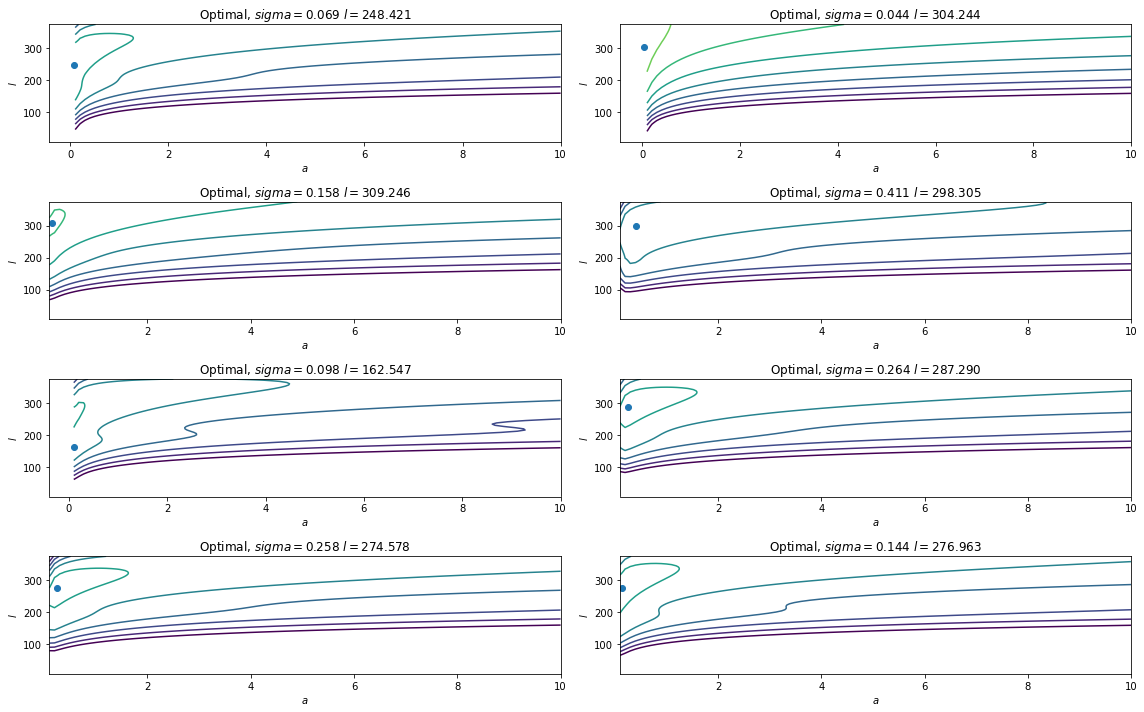

In [37]:
# Plotting the results of the scan

for i, pos_results in enumerate(scikit_scanned_locations):
  for j, comp_results in enumerate(pos_results):
    plt.subplot(len(scikit_scanned_locations), 2, 1 + 2*i + j)
    plot_scan_results(comp_results, level_range=(0, 200))
    
plt.tight_layout()

When using the scikit-learn algorithm, we can see from the plots that the contour lines are smoother than previously and that we find more or less the same length scale, $\ell$, but a much smaller value for $\sigma$.

While $\ell$ reaches a minimum from 162.547 to a maximum of 309.246 with an average of around 270 $\sigma$ on the other hand has a minimum from 0.044 to a maximum of 0.411 with an average of around 0.18.

The differences from the two models, that can be seen by comparing the plots, comes from the optimization target that is calculated diffrently, with the log-marginal-likelihood in the Scikit-learn -method which compares how likely the data is that we have seen under the chosen model that leads to penalizing the uncertainty more harshly by increasing the smoothness of the model, compared to the comparison of generalization error in the cross-validation process that accepts more uncertainty when picking its model.

## Predicting with the Gaussian Process

In the previous problem, we have found a good set of parameters to model the sequence of speeds at one location as a Gaussian process. Recall that we have assumed our 100 observations came at a rate of one every three days. We are going to assume that when we advance to our simulations, we will choose a smaller time step. Thus, we need to interpolate how the flow would look like at some unobserved points.

<b>You are given flow information every three days. Pick some time stamps in-between each observation for which to estimate the flow. For example, you want flows every day, so there will be two unknown points between two observations. You could pick only one, or more than two. Make your choice and explain why.</b>

Compute the conditional distribution (mean and covariance) at the time locations you selected previously with the kernel parameters that you obtained with the cross-validation.

For the initial estimate of the mean at the unknown time locations, you can use zero, use the average of all the observations, or take the average of the two closest observed points.

<b>Plot your predictions, clearly showing: 

- The predicted means.

- The predicted standard deviation as a $3\sigma$ (three standard deviations above and below the mean). 

- The observed data points.</b>

For the next step we try to predict the time stamps between the 3 days so we need to choose something that is less than this, for example we can choose time stamps at every 12 hours or 0.5 days. We create a function to compute the covariances and to make predictions for these time stamps, and plot the results of the predicted means, the predicted standard deviation as a way to show the uncertainty in the prediction and the observed data points.

In [50]:
# Function to generate covariances with the Gaussian Kernel

cov_params = (2, 285.0) # Fixed parameters

gen_cov = lambda z, w: gaussian_kernel(z, w, *cov_params) 

In [51]:
# Function to make predictions

def make_prediction(z, predicted_mean, gen_cov, obs, obs_means, obs_zs, obs_cov, tau):
  z = np.array([z])
  covs = [
               [ gen_cov(z, z), gen_cov(z, obs_zs) ],
               [ gen_cov(z, obs_zs), obs_cov ]
  ]
  pred_mean_cond, pred_var_cond = gaussian_process(np.array([predicted_mean]), obs_means, obs, covs, tau)
  return pred_mean_cond[0], pred_var_cond[0][0]

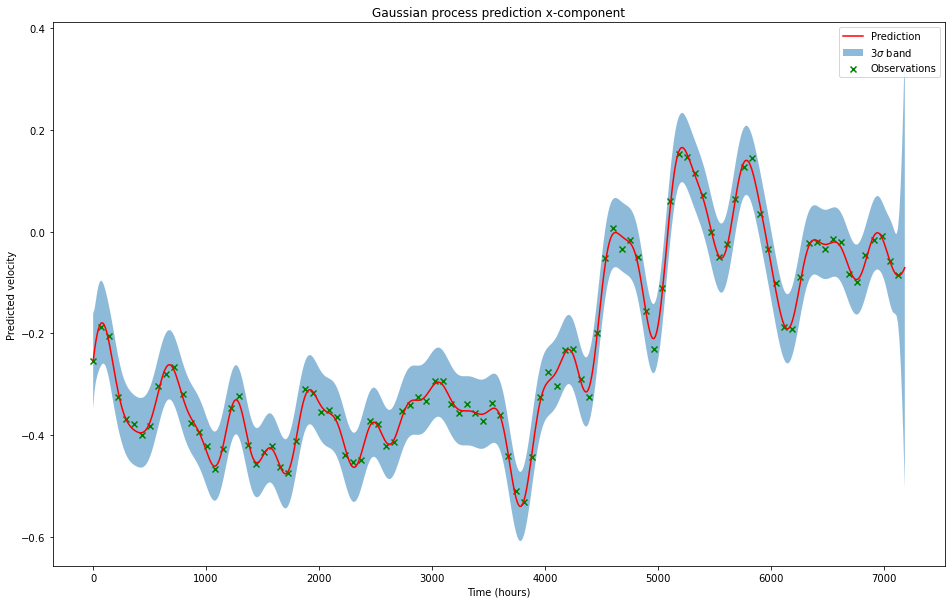

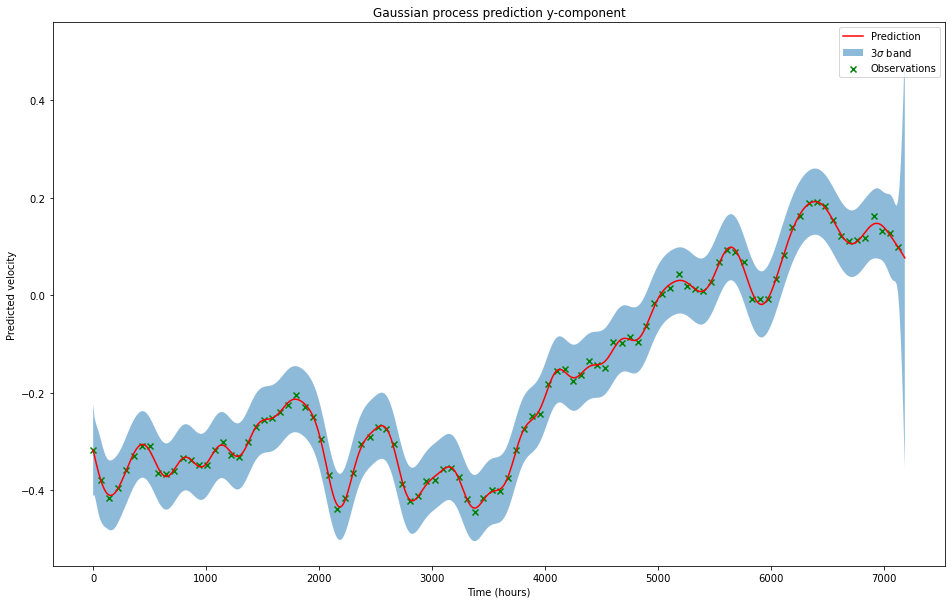

In [52]:
# Plotting the results of the prediction

def plot_prediction(pred_zs, predicted_mean, gen_cov, obs, obs_means, obs_zs, tau, title):
  obs_cov = gen_cov(obs_zs, obs_zs)
  zs = np.sort(np.concatenate([pred_zs, obs_zs]))
  preds = map(lambda z: make_prediction(z, predicted_mean, gen_cov, obs, obs_means, obs_zs, obs_cov, tau), zs)
  pred_means, pred_vars = map(np.array, zip(*preds))

  plt.fill_between(zs, pred_means - 3*np.sqrt(pred_vars), pred_means + 3*np.sqrt(pred_vars), alpha=0.5, label=r"$3\sigma$ band")
  plt.plot(zs, pred_means, c='r', label="Prediction")
  plt.scatter(obs_zs, obs, c='g', marker='x', label="Observations")
  plt.title("Gaussian process prediction {}".format(title))
  plt.xlabel("Time (hours)")
  plt.ylabel("Predicted velocity")
  plt.legend()
  plt.show()

obs_times = np.arange(0, 300, 3)*24.0 # hrs
pred_times = np.array(list(set(np.arange(0, 300, 0.5))-set(obs_times)))*(24.0) # hrs
for obs, title in zip(data[:, 1400//3, 400//3].T, ["x-component", "y-component"]):
  prior_means = obs.mean()*np.ones_like(obs) # Prior is the mean of the data over time.
  plot_prediction(pred_times, obs.mean(), gen_cov, obs, prior_means, obs_times, 0.001, title)

The Gaussian process regression model gives a predictive distribution whose mean and variance are functions of the input vector x. In the plots made with the Gaussian Process, the data points are marked with the green crosses, which are followed by the red line which shows the predicted means, and the shaded blue region corresponds to predicted plus and minus three standard deviations. We can plot a similar prediction by using the `scikit-learn` library to make a comparison with the models.

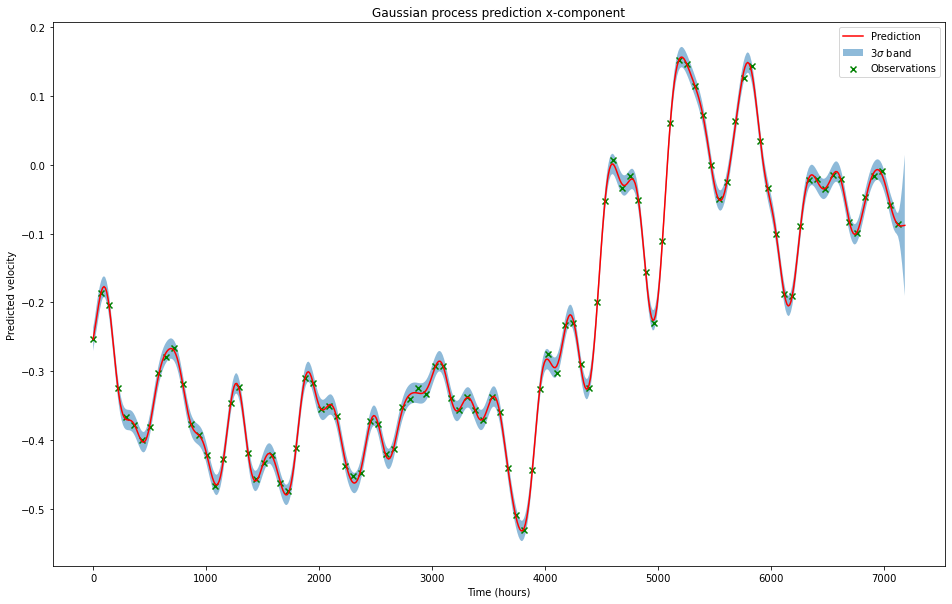

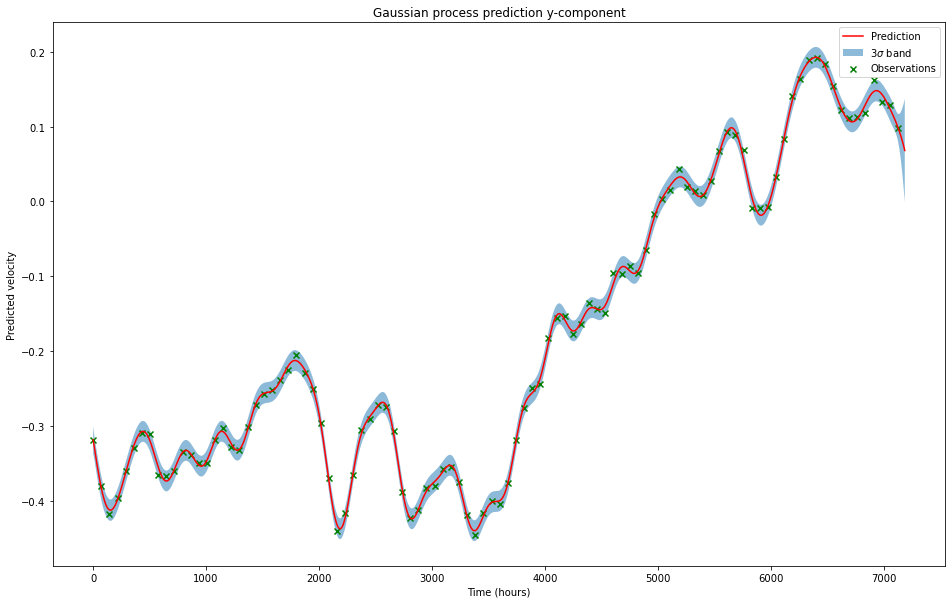

In [53]:
def plot_prediction(pred_zs, obs, obs_zs, tau, title):
  zs = np.sort(np.concatenate([pred_zs, obs_zs]))

  GPR = GaussianProcessRegressor(
        kernel = ConstantKernel(constant_value=cov_params[0], constant_value_bounds=(0.01, 100.0)) * RBF(length_scale=100.0, length_scale_bounds=(7.5, 375)), 
        alpha = tau, # this is basically tau
        normalize_y = True
        ).fit(obs_zs.reshape(-1, 1), obs)

  pred_means, pred_stds = GPR.predict(zs.reshape(-1, 1), return_std=True)
  pred_vars = pred_stds**2

  plt.fill_between(zs, pred_means - 3*np.sqrt(pred_vars), pred_means + 3*np.sqrt(pred_vars), alpha=0.5, label=r"$3\sigma$ band")
  plt.plot(zs, pred_means, c='r', label="Prediction")
  plt.scatter(obs_zs, obs, c='g', marker='x', label="Observations")
  plt.title("Gaussian process prediction {}".format(title))
  plt.xlabel("Time (hours)")
  plt.ylabel("Predicted velocity")
  plt.legend()
  plt.show()

for obs, title in zip(data[:, 1400//3, 400//3].T, ["x-component", "y-component"]):
  plot_prediction(pred_times, obs, obs_times, 0.001, title)

When comparing the two models, we notice that the `scikit-learn` library plots prediction with a a more narrow band of uncertainty and manages to capture the relationship between the data points in a more smoother way. Nevertheless, boths models follow the data poits quite nicely and seem to do a great job in interpolating the trajectory of the velocity between the data points. 

## Simulating with the Gaussian Process

In the previous problems, we learned to model the flow at one location as a Gaussian process. Thus, we can extend this to estimate the flow at any point in time at that particular location using the kernel function parameters. At a certain point in time, the flow can be computed as the realization of a multivariate Gaussian random variable with parameters given by the conditional distributions given the flow data. At this point, you are asked to simulate a particle moving according to the flow data and using the estimates for times between the original timestamps of the problem.

Ideally, one would have to estimate the parameters of the flow at every point in the map. However, having to run 504 x 555 parameter selection models seems like much computational work. So, here we take a more straightforward approach: use your results to choose a value of your kernel parameters that is generally representative of the points that you tested. 

<b>Modify the simulator that you built previously to use this new flow estimated flow information. Note that with this new change, you will be able to simulate the flow of particles for 300 days! Regarding data, originally, we have 100 measurements per point, now with this approach, let us say you use the estimates for two extra points to get one flow data per day, so in total, you should have at your disposal 300 descriptions of flow per location.

Now repeat the previous simulation. This time you will be simulating flows for 300 days. This allows some debris to arrive on land. Where are some possible places along the coast where one could find debris? Again, to do this, pick some $\sigma$ of your choice, and simulate the movement of particles with initial location sampled from the bivariate Gaussian. Evolve the location of the particles. Some times particles trajectories will terminate on the shore. Continue to keep track of such particles. These points are likely where you could find the debris.

Provide a plot that includes your initial, final, and at least one intermediate state of your simulation. For the final state, clearly mark one location on land where you would search for debris. Also mark one location over the ocean where you would search for debris. Provide a brief justification for both choices.

Try at least one other value for $\sigma$ , and create the same three plots. Comment if your conclusions should change.</b> 

For the longer simulations we will switch to JAX that makes the matrix calculations faster by using XLA, a linear algebra accelator originally developed for TesorFlow. JAX also offers some extra-features that are not available in NumPy, as well as enables the use of GPU.

First, we rewrite the Gaussian Process, Gaussian Kernel and the function that combines these into predicting the mean and variance of the multivariate Gaussian random variable in order to create a simulation for 300 days.

In [42]:
# Creating a Gaussian Process with JAX to compute the conditional probabilities

def jax_gaussian_process(x1_mean, x2_mean, x2, covs, tau):
    '''Computes the conditional mean and variance of datapoints with JAX.
    '''
    cov_noise = covs[1][1] + tau * jnp.eye(x2_mean.shape[0])
    x1_mean_cond_x2 = x1_mean + covs[0][1]@(jnp.linalg.solve(cov_noise, x2 - x2_mean))
    x1_cov_cond_x2 = covs[0][0] - covs[0][1]@(jnp.linalg.solve(cov_noise, covs[0][1].T))
    return x1_mean_cond_x2, x1_cov_cond_x2

In [43]:
# Creating a Gaussian Kernel with JAX to compute covariances

def jax_gaussian_kernel(zi, zj, sigma, ell):
    '''Computes the covariances with the squared exponential kernel function with JAX.
    '''
    covs = (sigma**2) * jnp.exp(- (zi[:, None] - zj[None, :])**2 / ell**2 )
    return covs

In [54]:
# Generating predictions with JAX

cov_params = (2, 285.0) # Fixed parameters

gen_cov = lambda z, w: jax_gaussian_kernel(z, w, *cov_params) 

def jax_make_prediction(z, predicted_mean, gen_cov, obs, obs_means, obs_zs, obs_cov, tau):
    '''Computes the predicted conditional mean and variance with JAX.
    '''
    z = jnp.array([z])
    covs = [
               [ gen_cov(z, z), gen_cov(z, obs_zs) ],
               [ gen_cov(z, obs_zs), obs_cov ]
  ]
    pred_mean_cond, pred_var_cond = jax_gaussian_process(jnp.array([predicted_mean]), obs_means, obs, covs, tau)
    return pred_mean_cond[0], pred_var_cond[0][0]

Next, we create the simulation that is similar to the previous 30 hour, except now we need to interpolate the missing timestamps to prolongue the timeframe to 300 days. This means we need to keep track also on the position of the velocity vector components as well as time. Otherwise, the algorithm follows a similar trajectory as before, where the simulation algorithm starts in the state $s_0$, which contains the initial position of each particle to be simulated, and the current time step of the simulation:
\begin{equation} s_0 = (x_0, t_0). \end{equation}

For each step of the simulation, the flow velocity is found by first digitizing the current flow velocity vectors, $v_i$ and $v_j$, and the current time step, $t_i$, of the simulation into an index for the data array of velocities. The digitization of the flow velocity vectors is performed through a binary search which is mapped into a JAX vmap operator that enables pararrel computation of the velocities by returning a new function that applies the original function to an entire vector. This vectorized mapping which leads to the calculation of the interpolated velocity vectors will help to speedup the execution considerably. The particle locations, $x_i$, are then digitized in the same way as before, but this time using JAX arrays of locations that mark the boundaries between data points. 

The current location of each particle is then advanced by one time step:
\begin{equation}
  x_{i+1} \leftarrow x_i + \epsilon v_{i+1},
\end{equation}
where $v_i$ is the velocity at step $i$ as detailed above, $x_{i+1}$ and $x_i$ are the next and current locations of the particles, and $\epsilon$ is the time delta between simulation steps.

The current time step of the simulation is also advanced by $\epsilon$:
\begin{equation}
  t_{i+1} \leftarrow t_i + \epsilon.
\end{equation}

In [45]:
# Computing velocity vectors with JAX

def jax_v_position(x, grid, g_x_edges, g_y_edges):
    '''Find the position of the horizontal and vertical velocity vectors on the grid with JAX.
    '''
    clamp = lambda ar, min_, max_: jnp.maximum(min_, jnp.minimum(max_, ar))
    vi = clamp(jnp.searchsorted(g_x_edges, x[:,0]), 1, g_x_edges.shape[0]-1)
    vj = clamp(jnp.searchsorted(g_y_edges, x[:,1]), 1, g_y_edges.shape[0]-1)
    return grid[:, vi-1,vj-1,:].T # (100, 555, 504, 2)

def get_v_func(gen_cov, t_grid, g_x_edges, g_y_edges, grid_cov, tau):
    '''Find the correct position on the grid and compute the velocity vectors with the
    Gaussian Process and Gaussian Kernel using JAX vmap for vectorized mapping.
    Prediction with z, predicted_mean, gen_cov, obs, obs_means, obs_zs, obs_cov, tau.
    Returning the function and data reshaped into vi and vj vectors.
    '''
  
    def v_func(t, x, grid):
      obs = jax_v_position(x, grid, g_x_edges, g_y_edges)

      rfun = jax.vmap(lambda o: jax_make_prediction(t, o.mean(), gen_cov, o, jnp.ones_like(o)*o.mean(), t_grid, grid_cov, tau)[0])
      return rfun(obs.reshape((-1, obs.shape[2]))).reshape((2, obs.shape[1])).T # all data shaped into vi and vj vectors
    return v_func

In [46]:
def jax_sim_gp(N, save_stride, t_edges, v_func, v_grid, x_0, epsilon):
  '''Makes the simulation based on the position in the index. Sets the state which
  is then updated after each step that is also saved.
  '''

  clamp = lambda ar, min_, max_: jnp.maximum(min_, jnp.minimum(max_, ar))

  def get_grid(t):
    vt = clamp(jnp.searchsorted(t_edges, t), 1, t_edges.shape[0]-1)
    return v_grid[vt-1]

  state_0 = (x_0, 0.0, v_func(0.0, x_0, v_grid), *get_grid(0.0).transpose([2,0,1]))
  
  def step(i, state):
    x, t, v, _, _ = state

    v_t_grid = get_grid(t) # Find time index
    v = v_func(t, x, v_grid) # Compute the velocities
    
    x = x + epsilon*v # Compute the next position value
    t = t + epsilon # Compute the next time
    
    new_state = (x, t, v, v_t_grid[:,:,0], v_t_grid[:,:,1])
    return new_state

  def save_step(state, i):
    new_state = jax.lax.fori_loop(i, i+save_stride, step, state)
    return new_state, new_state
  
  _, states = jax.lax.scan(save_step, state_0, xs=jnp.arange(0, N, save_stride))
  return states

@functools.partial(jax.jit, static_argnums=(0,1))
def jax_gp(N, save_stride, t_edges, g_x_edges, g_y_edges, v_grid, x_0, epsilon, sigma, ell, tau):
  '''Builds the grid with the edges and midpoint. Creates the covariance matrix and sets up
  function to calculate velocities before running the actual simulation.
  '''
    
  midpoint = lambda ar: (ar[1:] + ar[:-1])/2
  t_grid, x_grid, y_grid = map(midpoint, (t_edges, g_x_edges, g_y_edges))
 
  gen_cov = lambda z, w: jax_gaussian_kernel(z, w, sigma, ell)
  grid_cov = gen_cov(t_grid, t_grid)
  v_func = get_v_func(gen_cov, t_grid, g_x_edges, g_y_edges, grid_cov, tau)

  return jax_sim_gp(N, save_stride, t_edges, v_func, v_grid, x_0, epsilon)

In [47]:
# Setup for simulation

T = 24*300.0 # Simulation time in hours
N = 4*T # Number of iterations 
num = 100 # Number of particles 
epsilon = T/N # Time steps

grid_t_edges = np.arange(0, data.shape[0]+1)*3*24 # 7200 hrs / 300 days / 3 days per point
grid_x_edges = np.arange(0, data.shape[1]+1)*3 # 1665 km / 3 km per point
grid_y_edges = np.arange(0, data.shape[2]+1)*3 # 3km per point
midpoint = lambda ar: (ar[1:] + ar[:-1])/2
grid_x, grid_y = np.meshgrid(midpoint(grid_x_edges), midpoint(grid_y_edges), indexing='ij')

def plot_overlay(ax):
  ax.matshow(mask.T, origin='lower', extent=[0, grid_x_edges.max(), 0, grid_y_edges.max()])
  ax.axis([0, grid_x_edges.max(), 0, grid_y_edges.max()])

In [ ]:
# Simulating flowplot for 300 days where particles start at (300km, 1050km) with varying variance

for x_0_variance in [10**2, 50**2]:
  x_0 = np.random.multivariate_normal(mean=[300, 1050], cov=[[x_0_variance, 0], [0, x_0_variance]], size=num)

  plane_states = jax_gp(N, N//100, grid_t_edges, grid_x_edges, grid_y_edges, data, x_0, epsilon, *cov_params+(0.001,))
  plane_states_numpy = list(zip(*map(np.array, plane_states)))

animate(plane_states_numpy, grid_x, grid_y, "{}", overlay=plot_overlay, grid_stride=20, density=False)

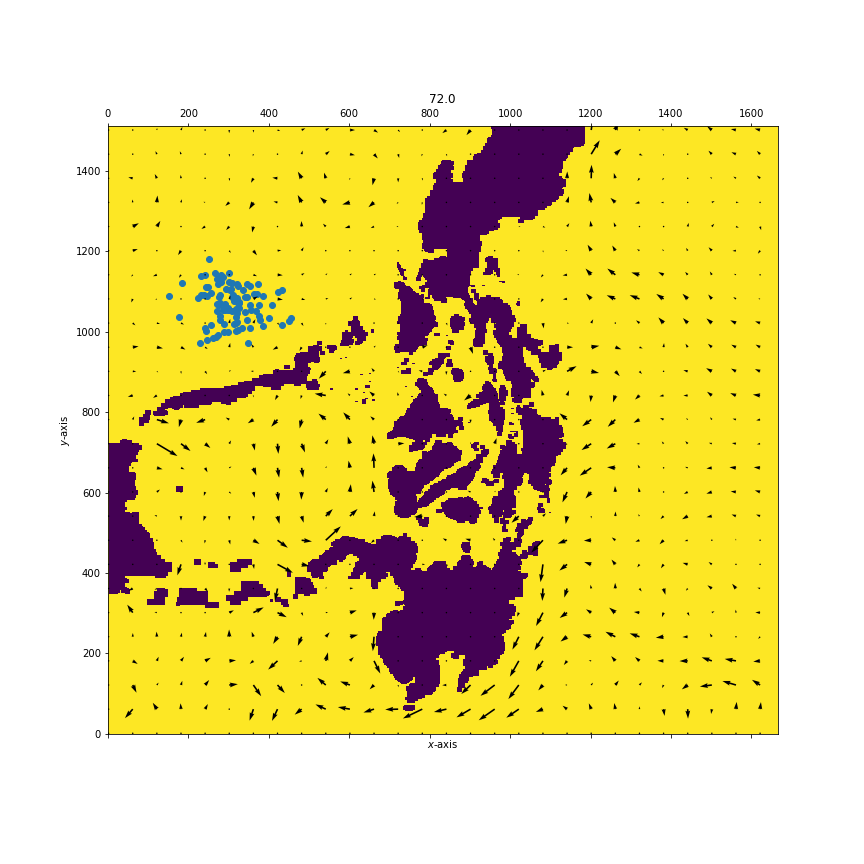

The first picture shows the start of the simulation after 72 hours of the crash with 100 particles with a low variance on the spread of the particles while the second picture below shows the same but with a higher variance to start with.

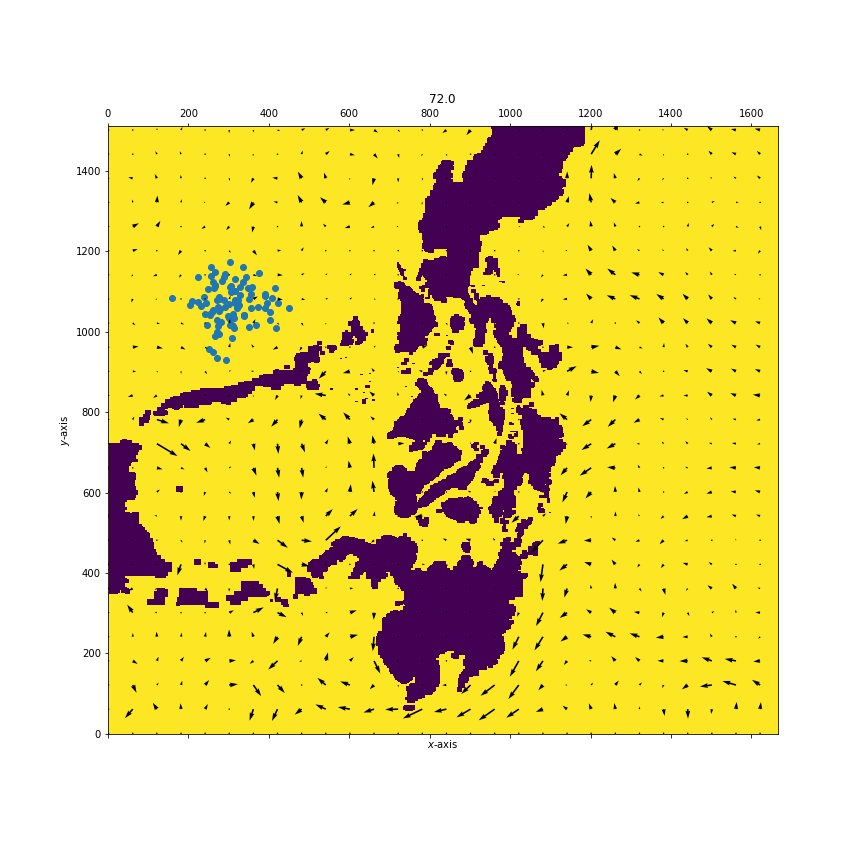

The next picture below shows again the movement of the particles after 3600 hours or 150 days have passed since the cash starting with a lower variance.

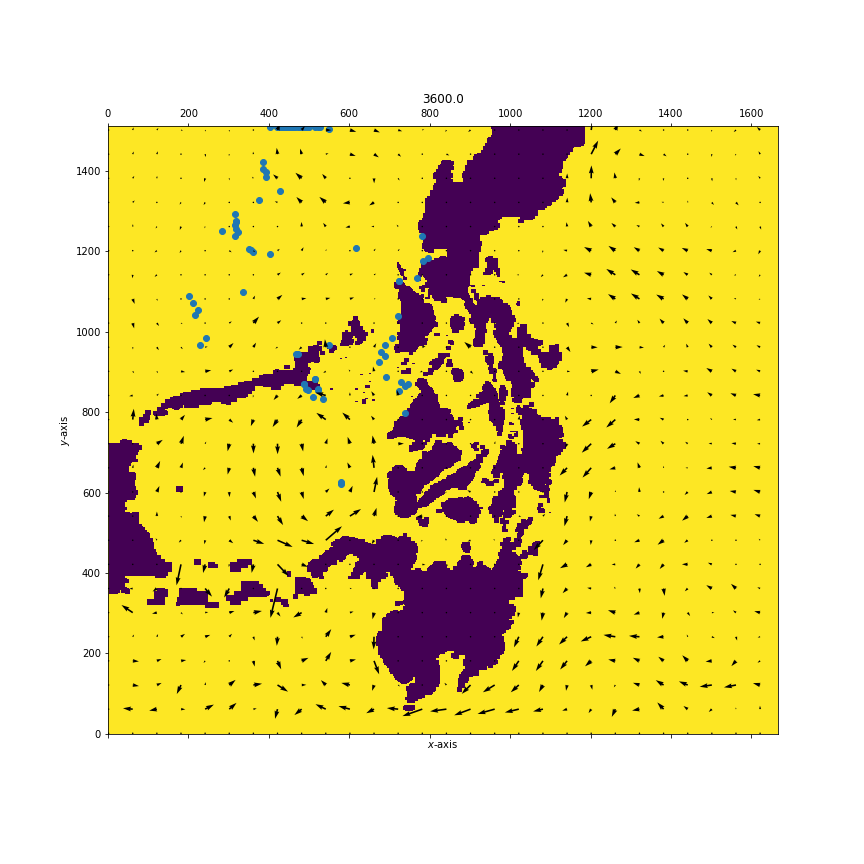

We can see from the picture below that the spread of the particles that started with a higher variance is similar to that with a lower variance at the 3600 hour mark.

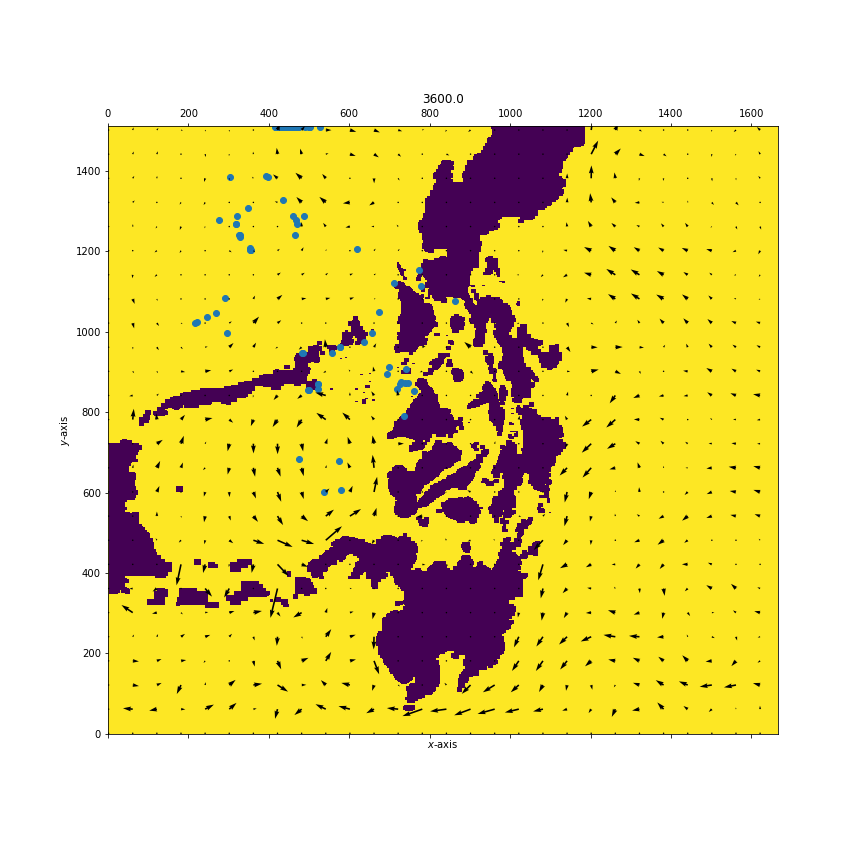

The last two pictures show the end of the simulation at 7200 hours, starting from the lower variance and ending to the higher variance.

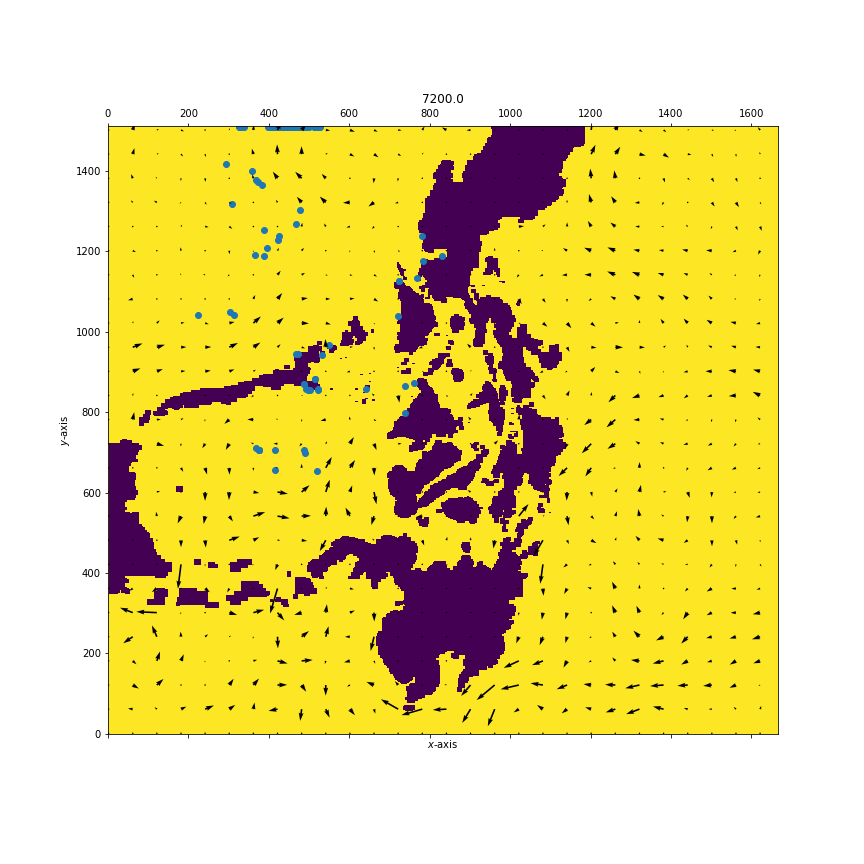

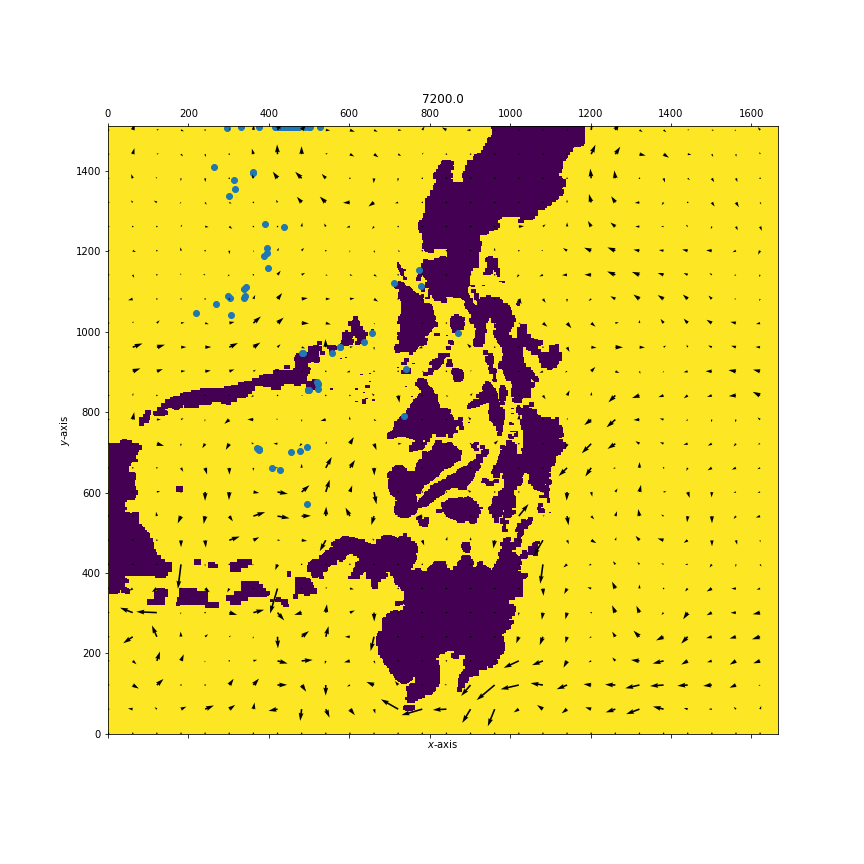

Compared to the 30 hour simulation, this time we can see that most of the particles are turning in a circle just a bit north of the crash site so it would be a good place to start the search. After 300 days have passed, we see some of the particles drifting towards South-West and some finding their way into South towards Imuruan Bay and Sulu Sea. Finally, we see many particles landing at the Dumaran Island so this would also be a good place to have a look. The increase of variance increases the amount of particles landing to different parts of the coast of the Philippines.

<b>Thanks to your efforts, most parts of the (toy) plane were found, either inland or in the sea. As a final stage, you are tasked with locating three new monitoring stations on the coast. The purpose of these stations is to monitor general ocean debris. Using the tools you have build in this homework, propose the location of such three new stations. Simulate the trajectories of as many particles as you want, initialized at random locations uniformly distributed on the map. This is essentially a repeat of the first simulation, but this time, remove particles that start on land so that they do not confuse your conclusions.

Many of the particles will end up on the coast. A good location for a monitoring station will be areas where many of such particles land on the coast.

Provide a plot that includes your initial, final, and at least one intermediate state of your simulation. For the final state, clearly mark where you would place your three monitoring stations. Provide a justification for why you chose these locations.</b> 

In [ ]:
# Setup for simulation

# Starting particles randomly around the map. but only at the Sea
x_0 = np.array([ np.random.rand(num)*grid_x_edges.max(), np.random.rand(num)*grid_y_edges.max() ]).T
x_0 = x_0[np.square(jax_v_position(x_0, data, grid_x_edges, grid_y_edges).T[0]).sum(axis=1) > 0]

midpoint = lambda ar: (ar[1:] + ar[:-1])/2
grid_x, grid_y = np.meshgrid(midpoint(grid_x_edges), midpoint(grid_y_edges), indexing='ij')
monitoring_states = jax_gp(N, N//100, grid_t_edges, grid_x_edges, grid_y_edges, data, x_0, epsilon, *cov_params+(0.001,))
monitoring_states_numpy = list(zip(*map(np.array, monitoring_states)))
animate(monitoring_states_numpy, grid_x, grid_y, "{}", overlay=plot_overlay, grid_stride=20, density=True)

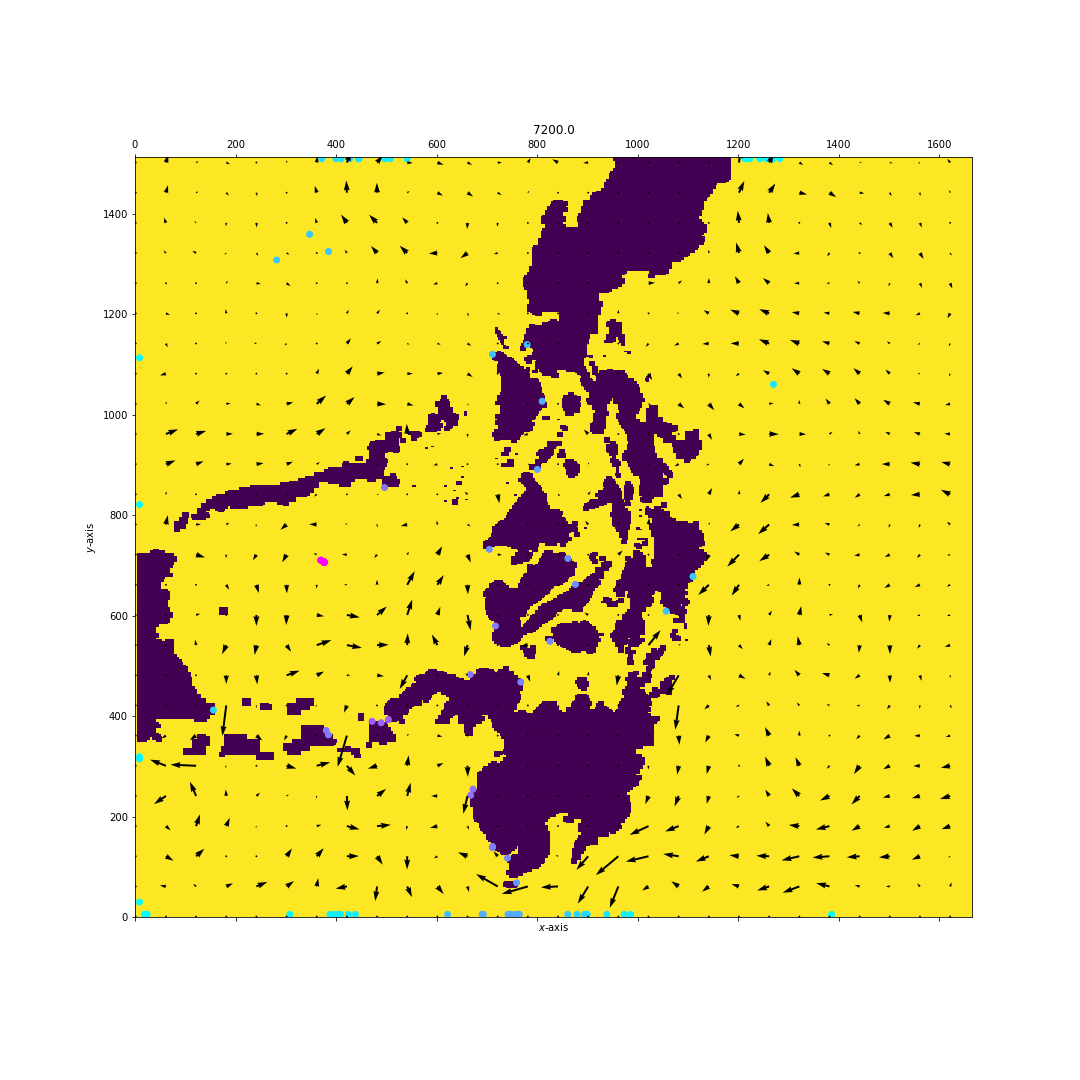

Good places to monitor the area would be to create the monitoring posts so that they would cover as much space as possible. Having this in mind, and after running the simulation with different number of particles and configurating the densities with KDE, the first location should be on the Southern point of the Philippines, in the island of the Municipality of Sarangani. The second place would be the same as in the previous simulation, in the Sulu Sea at the Dumuran Island. Finally, for the third monitoring station, a good place would be in the Southern point of the Sulu Sea at the Basilan Island. If we run the simulation with various different settings, these three spots land the most the particles due to the ocean currents and thus would be the best spots for monitoring the sea near the Philippines.